<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Project Description

**Goal of the Project**
 Use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

Specifically, build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.practice machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

**Context**

Forecasts aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing.

**Potential Impact**

If successful, you'll have flexed some new skills in a real world example. For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction. The results of this ongoing competition, over time, might even ensure your local store has exactly what you need the next time you shop.

**Dataset Description**

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

**File Descriptions and Data Field Information**

**train.csv**

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

**sample_submission.csv**

A sample submission file in the correct format.

**stores.csv**

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

**oil.csv**

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**

Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Prepare Data

In [1]:
%%capture

# importing dependencies 

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 300

!pip install pycaret
#!pip install autoviz
import pycaret

from ydata_profiling import ProfileReport

In [2]:
# get the csv files

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df_name = filename.replace('.csv', '') + '_df'
        # print(f'{df_name} = pd.read_csv("{os.path.join(dirname, filename)}")')

In [3]:
# read the data

oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=['date'])

sample_submission_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")

holidays_events_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=['date'])

stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates=['date'])

test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=['date'])

transactions_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates=['date'])

In [4]:
# get the first 3 rows of each dataset

dfs = [oil_df, sample_submission_df, holidays_events_df, stores_df, train_df, test_df, transactions_df]
dfstr = ['oil_df', 'sample_submission_df', 'holidays_events_df', 'stores_df', 'train_df', 'test_df', 'transactions_df']

for i in range(len(dfs)):
    print(f'###@@@ {dfstr[i]} @@@###')
    display(dfs[i].head(3))
    print('\n')

###@@@ oil_df @@@###


date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97



###@@@ sample_submission_df @@@###


id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0



###@@@ holidays_events_df @@@###


date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   

   transferred  
0        False  
1        False  
2        False



###@@@ stores_df @@@###


store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13
2          3  Quito  Pichincha    D        8



###@@@ train_df @@@###


id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0



###@@@ test_df @@@###


id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2



###@@@ transactions_df @@@###


date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358

In [5]:
# get info of each dataframe

for i in range(len(dfs)):
    print(f'###@@@ {dfstr[i]} @@@###')
    display(dfs[i].info())
    print('\n')

###@@@ oil_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


None



###@@@ sample_submission_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


None



###@@@ holidays_events_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None



###@@@ stores_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None



###@@@ train_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


None



###@@@ test_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


None



###@@@ transactions_df @@@###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


None

In [6]:
# get description of each dataframe

for i in range(len(dfs)):
    print(f'###@@@ {dfstr[i]} @@@###')
    display(dfs[i].describe())
    print('\n')

###@@@ oil_df @@@###


dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000



###@@@ sample_submission_df @@@###


id    sales
count  2.851200e+04  28512.0
mean   3.015144e+06      0.0
std    8.230850e+03      0.0
min    3.000888e+06      0.0
25%    3.008016e+06      0.0
50%    3.015144e+06      0.0
75%    3.022271e+06      0.0
max    3.029399e+06      0.0



###@@@ holidays_events_df @@@###


date     type    locale locale_name description  \
count                   350      350       350         350         350   
unique                  312        6         3          24         103   
top     2014-06-25 00:00:00  Holiday  National     Ecuador    Carnaval   
freq                      4      221       174         174          10   
first   2012-03-02 00:00:00      NaN       NaN         NaN         NaN   
last    2017-12-26 00:00:00      NaN       NaN         NaN         NaN   

       transferred  
count          350  
unique           2  
top          False  
freq           338  
first          NaN  
last           NaN



###@@@ stores_df @@@###


store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000



###@@@ train_df @@@###


id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02



###@@@ test_df @@@###


id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000
75%    3.022271e+06     41.000000      6.000000
max    3.029399e+06     54.000000    646.000000



###@@@ transactions_df @@@###


store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000

# Data Validation 

In [7]:
# shape of each df

print('The shape of each df:\n')

for i in range(len(dfs)):
    print(f'DateFrame: {dfstr[i]} --> {dfs[i].shape}\n')

The shape of each df:

DateFrame: oil_df --> (1218, 2)

DateFrame: sample_submission_df --> (28512, 2)

DateFrame: holidays_events_df --> (350, 6)

DateFrame: stores_df --> (54, 5)

DateFrame: train_df --> (3000888, 6)

DateFrame: test_df --> (28512, 5)

DateFrame: transactions_df --> (83488, 3)



Let's find out how many missing values in each dataset:

+ Answer: only `oil_df` has 43 missing values (unclear why)

In [8]:
# row sum of missing values

for i in range(len(dfs)):
    if dfs[i].isna().sum().sum() > 0:
        print(f'DateFrame: {dfstr[i]}\n{dfs[i].isna().sum().sum()} null values', '\n')
    else:
        print(f'DateFrame: {dfstr[i]}\nNO null', '\n')

DateFrame: oil_df
43 null values 

DateFrame: sample_submission_df
NO null 

DateFrame: holidays_events_df
NO null 

DateFrame: stores_df
NO null 

DateFrame: train_df
NO null 

DateFrame: test_df
NO null 

DateFrame: transactions_df
NO null 



Let's first see when are the missing values occure and then fix them in the `oil_df`.

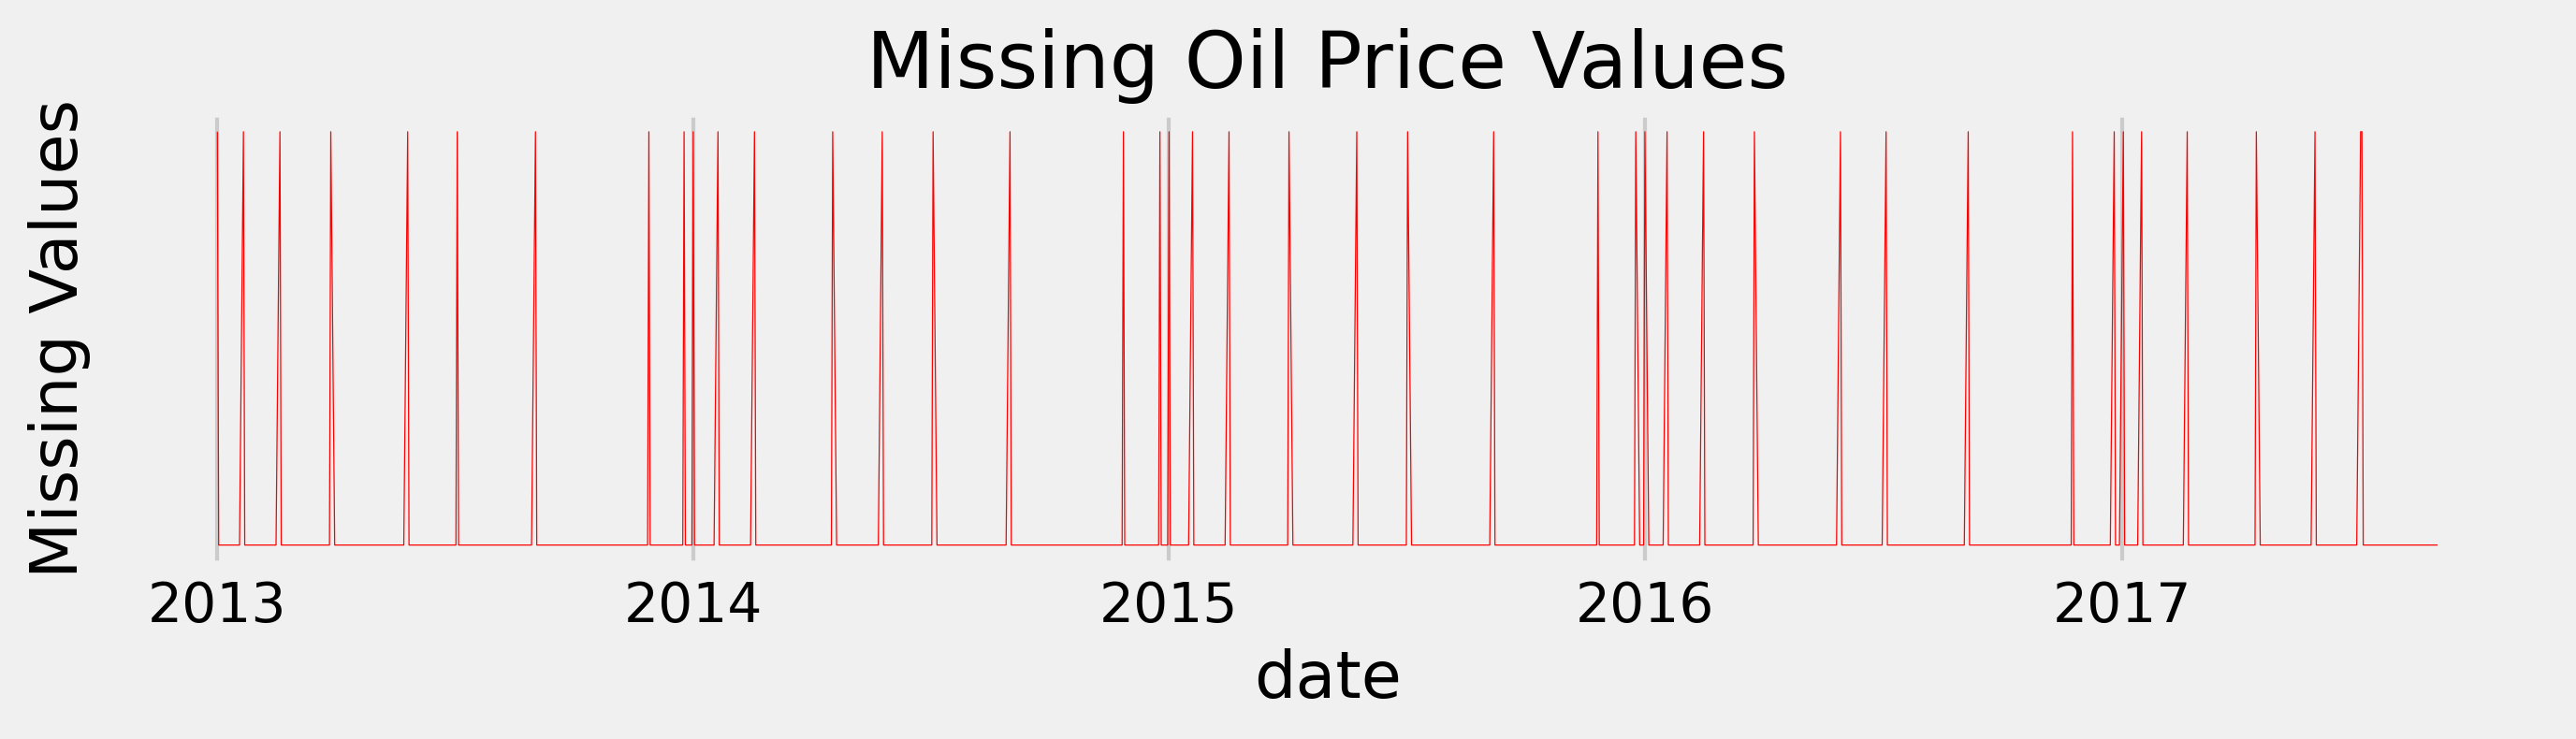

In [9]:
# plot missing values in the oil_df

plt.figure(figsize=(10,2))
sns.lineplot(data=oil_df.assign(nan=np.where(oil_df.dcoilwtico.isna(),1,0)), x='date', y='nan', lw=0.3, color='r')
plt.yticks([])
plt.ylabel('Missing Values')
plt.title('Missing Oil Price Values')
plt.show()

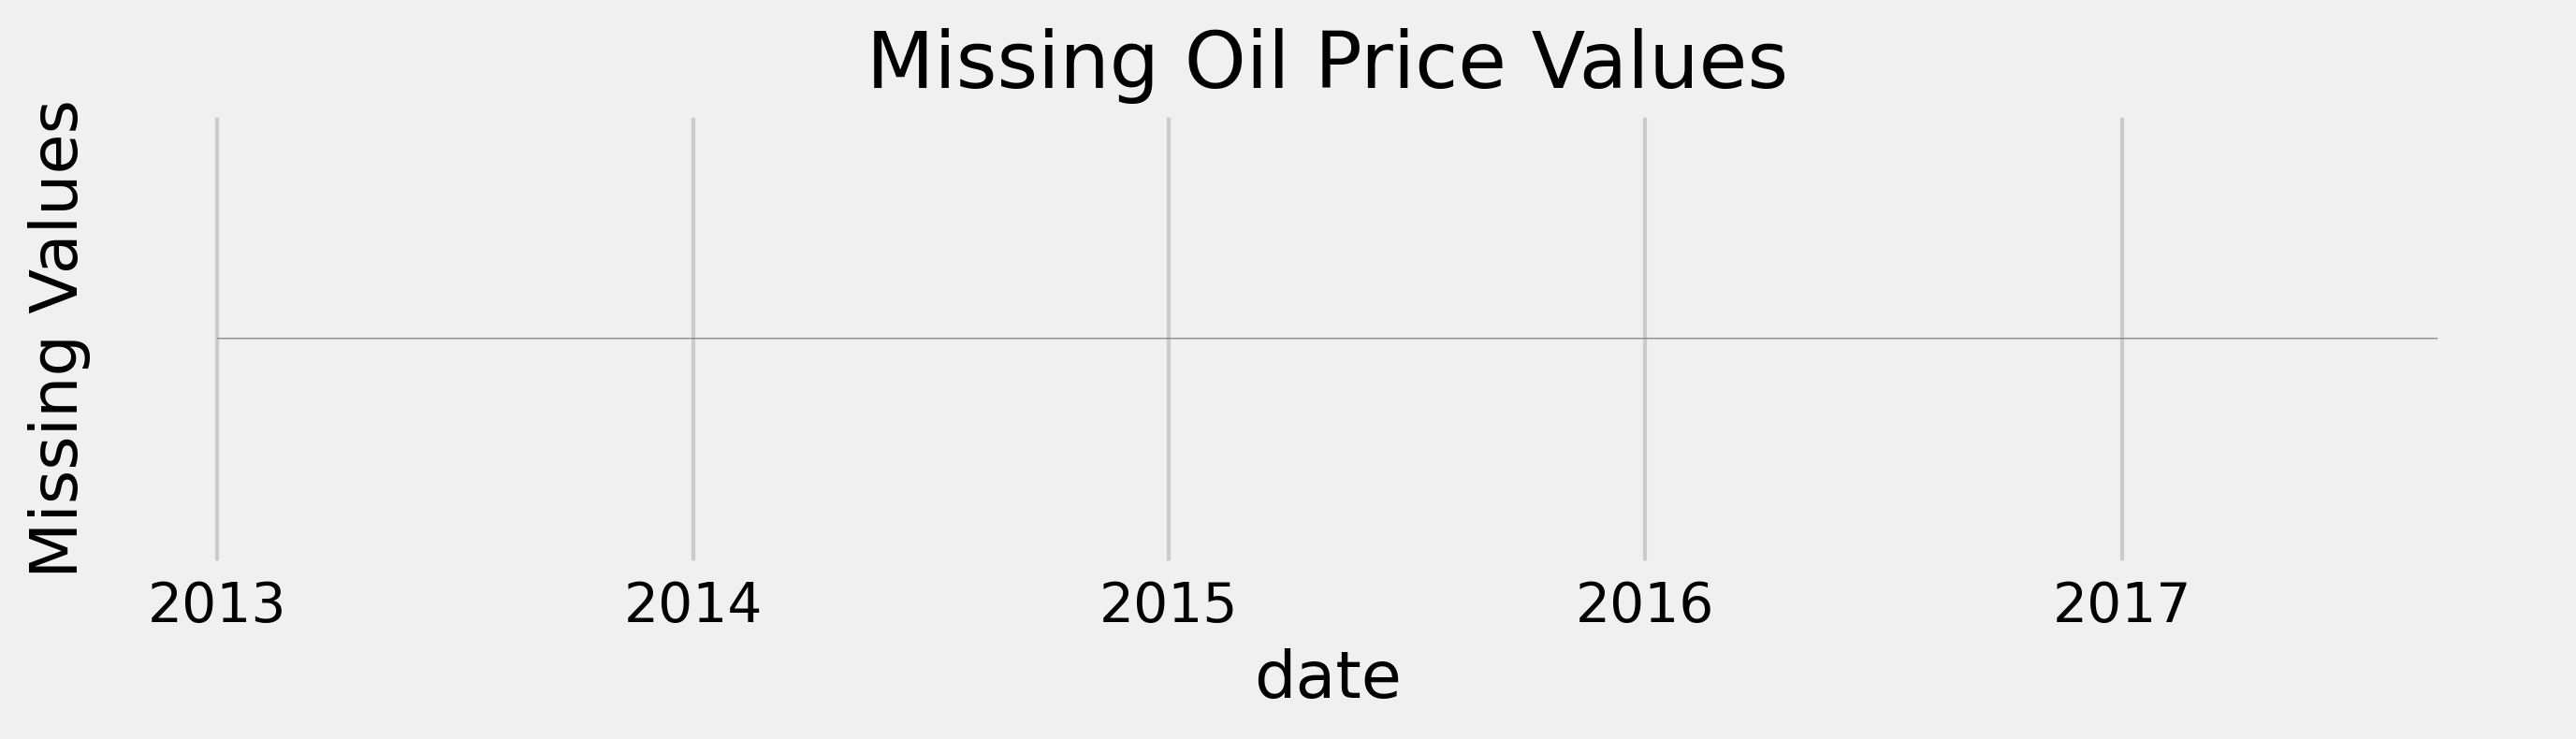

In [10]:
# correcting missing values in the oil_df

oil_df.dcoilwtico.fillna(method='backfill', inplace=True)

# plot missing values in the oil_df after filling

plt.figure(figsize=(10,2))
sns.lineplot(data=oil_df.assign(nan=np.where(oil_df.dcoilwtico.isna(),1,0)), x='date', y='nan', lw=0.3, color='gray')
plt.yticks([])
plt.ylabel('Missing Values')
plt.title('Missing Oil Price Values')
plt.show()

Dates in the datasets are converted to `objects` or text.

+ The `pd.read_csv` will be corrected in the early steps to convert dates to `date objects` instead.

In [11]:
# data types of each dataset

for i in range(len(dfs)):
    viz = (dfs[i].dtypes
                 .to_frame() # make it look nice
                 .T          # transpose the table (horizontal)
                 .rename(index={0:f'{dfstr[i]}'})) # renameing the row
    display(viz)

date dcoilwtico
oil_df  datetime64[ns]    float64

id    sales
sample_submission_df  int64  float64

date    type  locale locale_name description  \
holidays_events_df  datetime64[ns]  object  object      object      object   

                   transferred  
holidays_events_df        bool

store_nbr    city   state    type cluster
stores_df     int64  object  object  object   int64

id            date store_nbr  family    sales onpromotion
train_df  int64  datetime64[ns]     int64  object  float64       int64

id            date store_nbr  family onpromotion
test_df  int64  datetime64[ns]     int64  object       int64

date store_nbr transactions
transactions_df  datetime64[ns]     int64        int64

# Data Joining

Let's create two master dataframes for `training` and `testing` datasets. Each master dataframe will have relevant values from all of the original dataframes.

In [12]:
# join the train data with store, holiday, oil, and transaction datasets

train_master = pd.merge(train_df, oil_df, on='date', how='left').fillna(method='ffill')
train_master = pd.merge(train_master, stores_df, on='store_nbr', how='left')
train_master = pd.merge(train_master, transactions_df, on=['date', 'store_nbr'], how='left').fillna('0')
train_master = pd.merge(train_master, 
                         holidays_events_df[['date', 'type', 'locale', 'transferred']], 
                         on='date', how='left', suffixes=('_store', '_holiday'))\
                         .drop_duplicates(subset=['id']).reset_index(drop=True)

# join the test data with store, holiday, oil, and transaction datasets

test_master = pd.merge(test_df, oil_df, on='date', how='left').fillna(method='ffill')
test_master = pd.merge(test_master, stores_df, on='store_nbr', how='left')
test_master = pd.merge(test_master, transactions_df, on=['date', 'store_nbr'], how='left').fillna('0')
test_master = pd.merge(test_master, 
                       holidays_events_df[['date', 'type', 'locale', 'transferred']], 
                       on='date', how='left', suffixes=('_store', '_holiday'))\
                       .drop_duplicates(subset=['id']).reset_index(drop=True)

In [13]:
# validate both new datasets are the same (in index) as the old datasets

print((train_master[['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']].index == train_df.index).all())
print((test_master[['id', 'date', 'store_nbr', 'family', 'onpromotion']].index == test_df.index).all())

True
True


In [14]:
# fill missing values in type_holiday, locale, transferred

train_master.loc[train_master['type_holiday'].isna(), 'type_holiday'] = 'Not Any'
train_master.loc[train_master['locale'].isna(), 'locale'] = 'Not Any'
train_master.loc[train_master['transferred'].isna(), 'transferred'] = False

test_master.loc[test_master['type_holiday'].isna(), 'type_holiday'] = 'Not Any'
test_master.loc[test_master['locale'].isna(), 'locale'] = 'Not Any'
test_master.loc[test_master['transferred'].isna(), 'transferred'] = False

In [15]:
# number of any missing values

print('train_master: ',train_master.isna().sum().sum())
print('test_master: ',test_master.isna().sum().sum())

train_master:  0
test_master:  0


In [16]:
# show the new datasets

display(train_master.head(4))
display(test_master.head(4))

id       date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0       93.14   
1   1 2013-01-01          1   BABY CARE    0.0            0       93.14   
2   2 2013-01-01          1      BEAUTY    0.0            0       93.14   
3   3 2013-01-01          1   BEVERAGES    0.0            0       93.14   

    city      state type_store  cluster transactions type_holiday    locale  \
0  Quito  Pichincha          D       13            0      Holiday  National   
1  Quito  Pichincha          D       13            0      Holiday  National   
2  Quito  Pichincha          D       13            0      Holiday  National   
3  Quito  Pichincha          D       13            0      Holiday  National   

  transferred  
0       False  
1       False  
2       False  
3       False

id       date  store_nbr      family  onpromotion  dcoilwtico   city  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0        46.8  Quito   
1  3000889 2017-08-16          1   BABY CARE            0        46.8  Quito   
2  3000890 2017-08-16          1      BEAUTY            2        46.8  Quito   
3  3000891 2017-08-16          1   BEVERAGES           20        46.8  Quito   

       state type_store  cluster transactions type_holiday   locale  \
0  Pichincha          D       13            0      Not Any  Not Any   
1  Pichincha          D       13            0      Not Any  Not Any   
2  Pichincha          D       13            0      Not Any  Not Any   
3  Pichincha          D       13            0      Not Any  Not Any   

  transferred  
0       False  
1       False  
2       False  
3       False

# Exploratory Data Analysis (EDA)

According to Kaggle challenge description, "Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices." Let's see if there's a relationship between the two!

In the chart below, we see that oil prices decrease after 2015 & average sales increase in Corporación Favorita. 

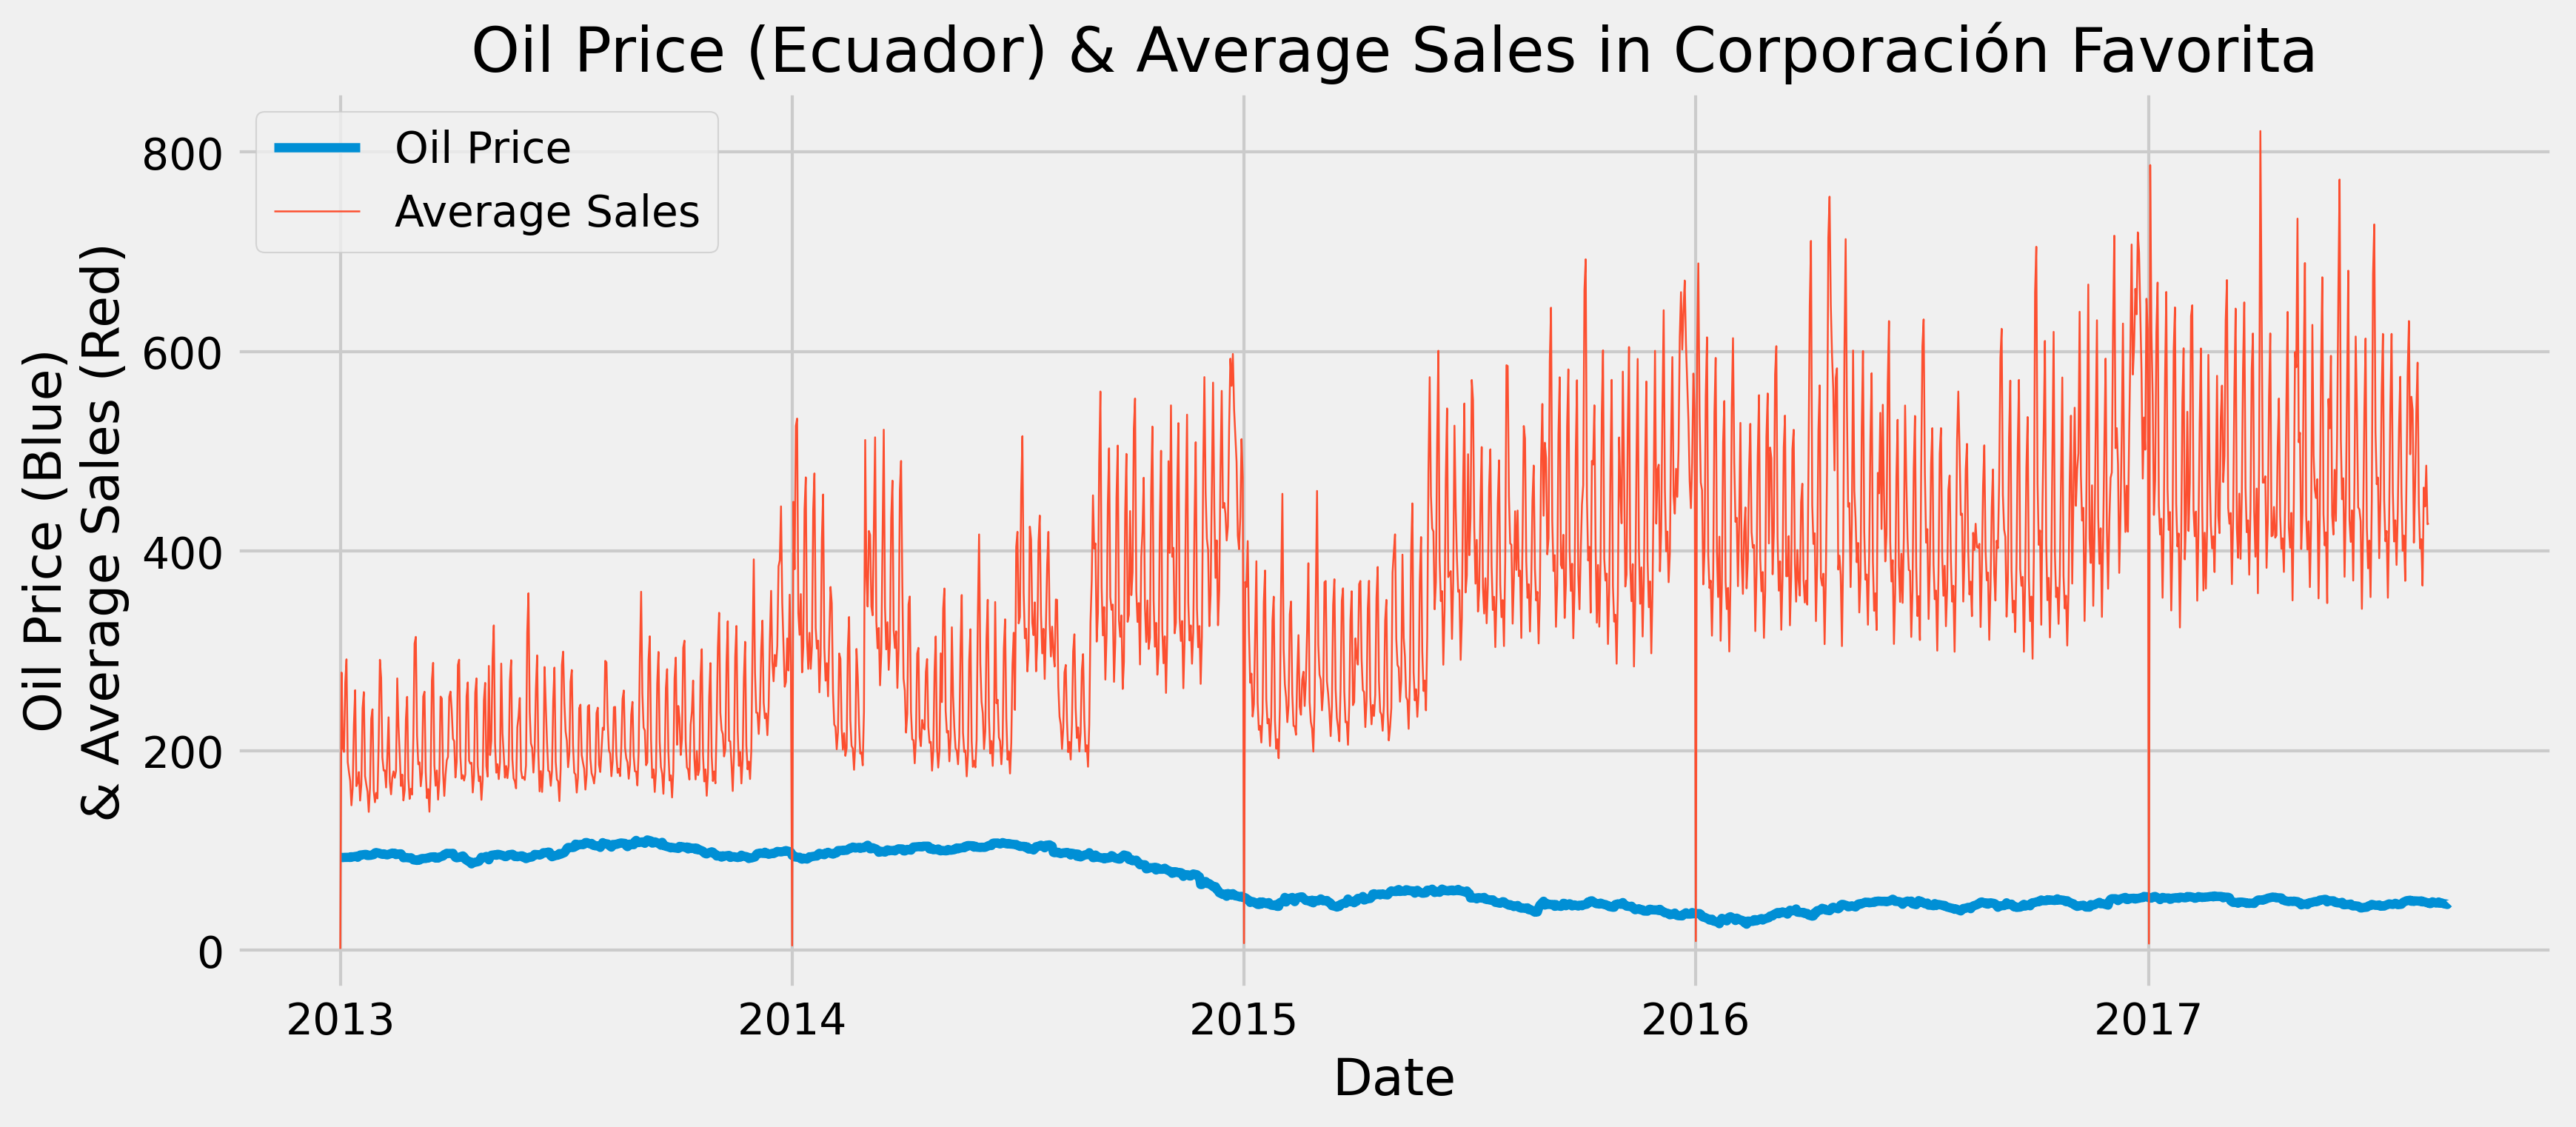

In [17]:
# change size of chart
plt.figure(figsize=(12, 5))

# draw lines
sns.lineplot(x=oil_df.date, y=oil_df.dcoilwtico, lw=3, label='Oil Price')
sns.lineplot(data=train_df.groupby('date')['sales'].mean().reset_index(), x='date', y='sales', 
             lw=0.6, label='Average Sales')

# sdd labels and title
plt.xlabel("Date")
plt.ylabel("Oil Price (Blue)\n & Average Sales (Red)")
plt.title("Oil Price (Ecuador) & Average Sales in Corporación Favorita")

# show the plot
plt.show()

Here're the above chart but each with their axes.

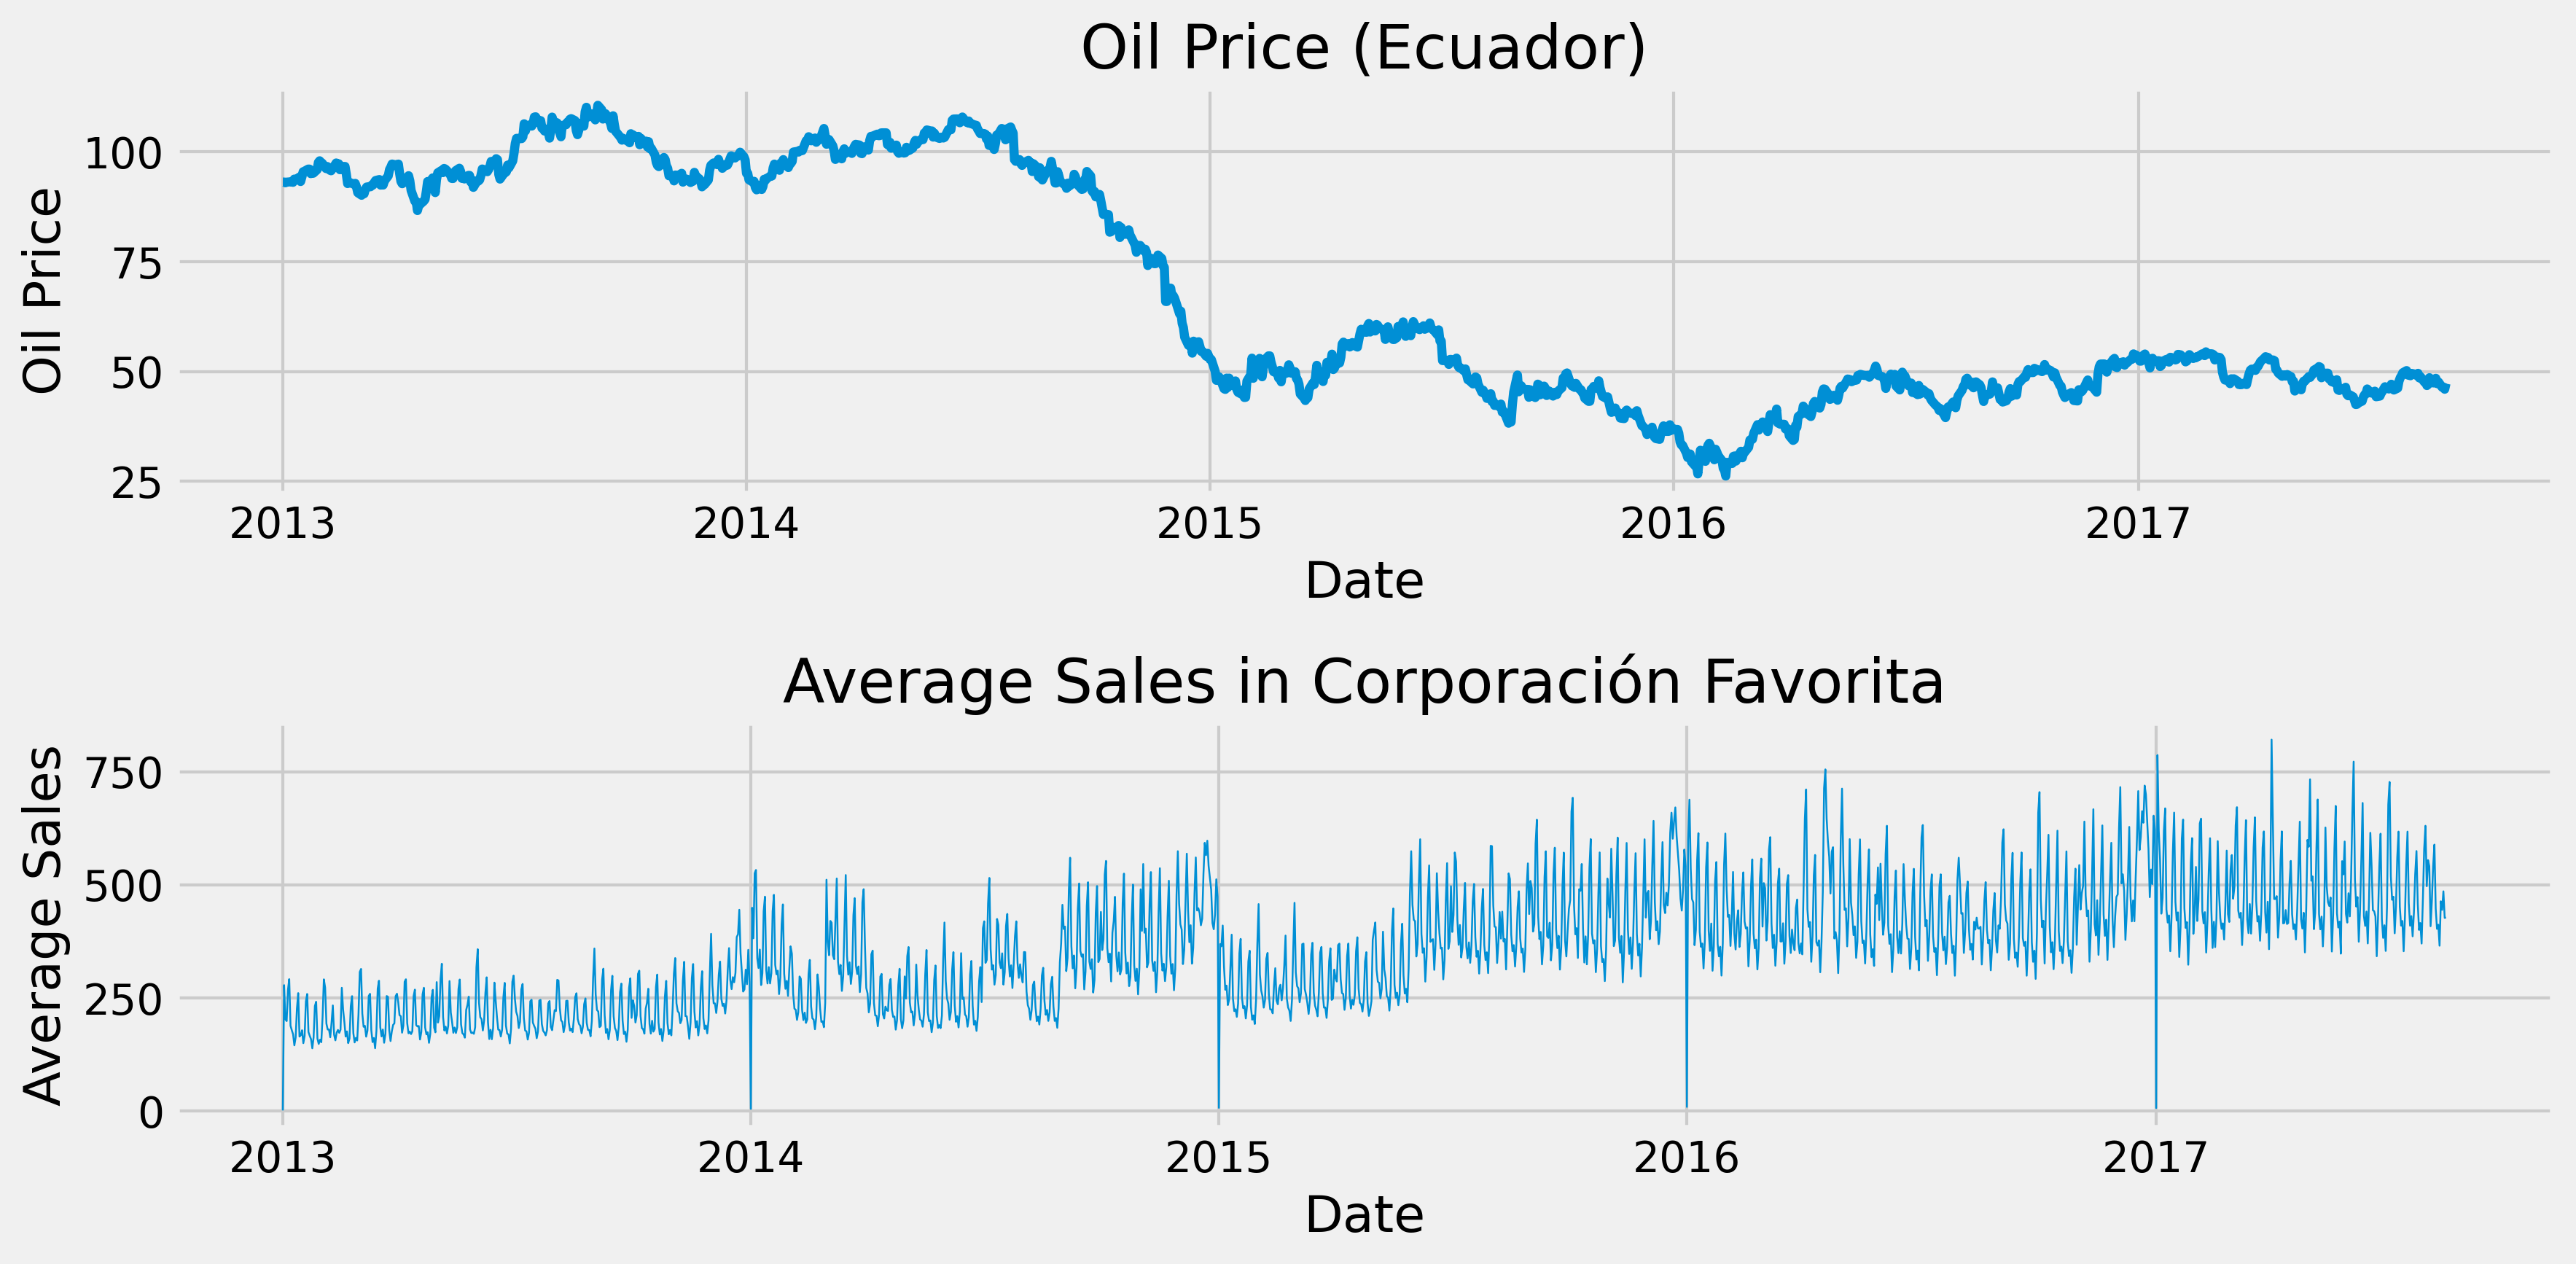

In [18]:
# Create a grid of subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Draw the first line plot for Oil Price on the first subplot
sns.lineplot(x=oil_df.date, y=oil_df.dcoilwtico, lw=3, ax=axes[0])

# Add labels and title for the first subplot
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Oil Price")
axes[0].set_title("Oil Price (Ecuador)")

# Draw the second line plot for Average Sales on the second subplot
sns.lineplot(data=train_df.groupby('date')['sales'].mean().reset_index(), x='date', y='sales', lw=0.6, ax=axes[1])

# Add labels and title for the second subplot
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Average Sales")
axes[1].set_title("Average Sales in Corporación Favorita")

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

Holidays don't seem to have a direct relationship with sales.

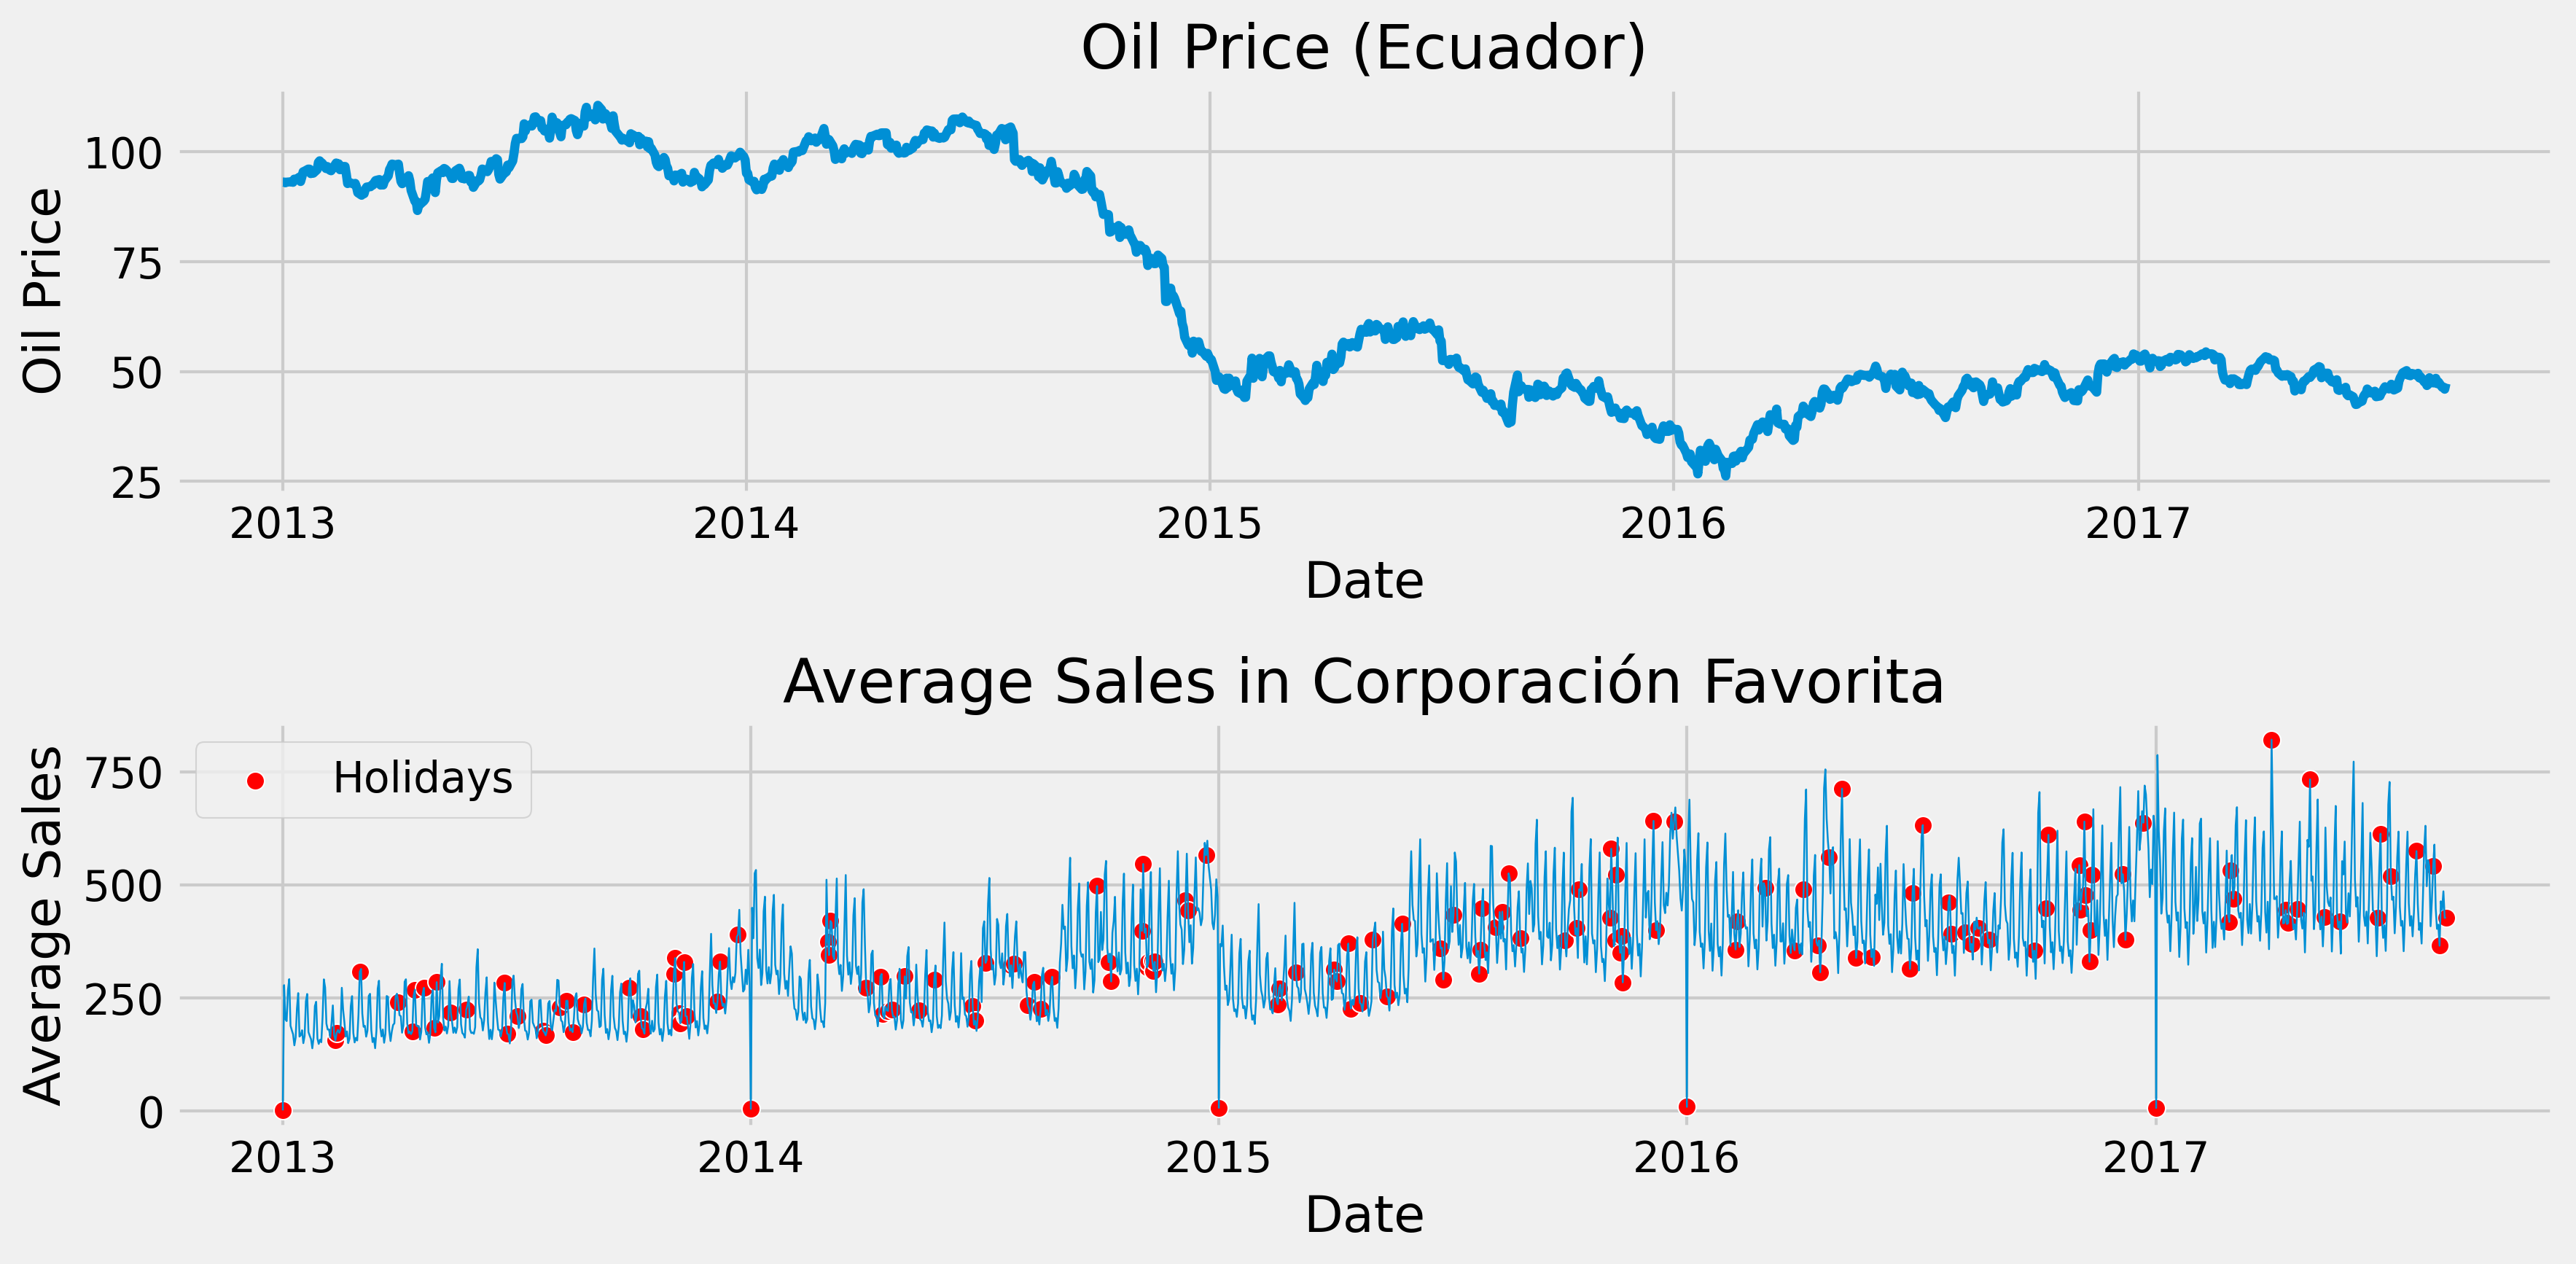

In [19]:
merged_df = pd.merge(left=train_df.groupby('date')['sales'].mean().reset_index(), 
                     right=holidays_events_df.loc[lambda df: (df['date']>='2013-01-01') & \
                           (df['type']=='Holiday')][['date','type']], 
                     how='left', 
                     on='date').fillna('False')

# Create a grid of subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Draw the first line plot for Oil Price on the first subplot
sns.lineplot(x=oil_df.date, y=oil_df.dcoilwtico, lw=3, ax=axes[0])

# Add labels and title for the first subplot
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Oil Price")
axes[0].set_title("Oil Price (Ecuador)")

# Draw the second line plot for Average Sales on the second subplot
sns.lineplot(data=train_df.groupby('date')['sales'].mean().reset_index(), x='date', y='sales', lw=0.6, ax=axes[1])
sns.scatterplot(data=merged_df.query('type == "Holiday"'), x='date', y='sales', ax=axes[1], color='red', label='Holidays')

# Add labels and title for the second subplot
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Average Sales")
axes[1].set_title("Average Sales in Corporación Favorita")

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

According to Kaggle, "A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake."

We can see an increase in the avg. sales during that time.

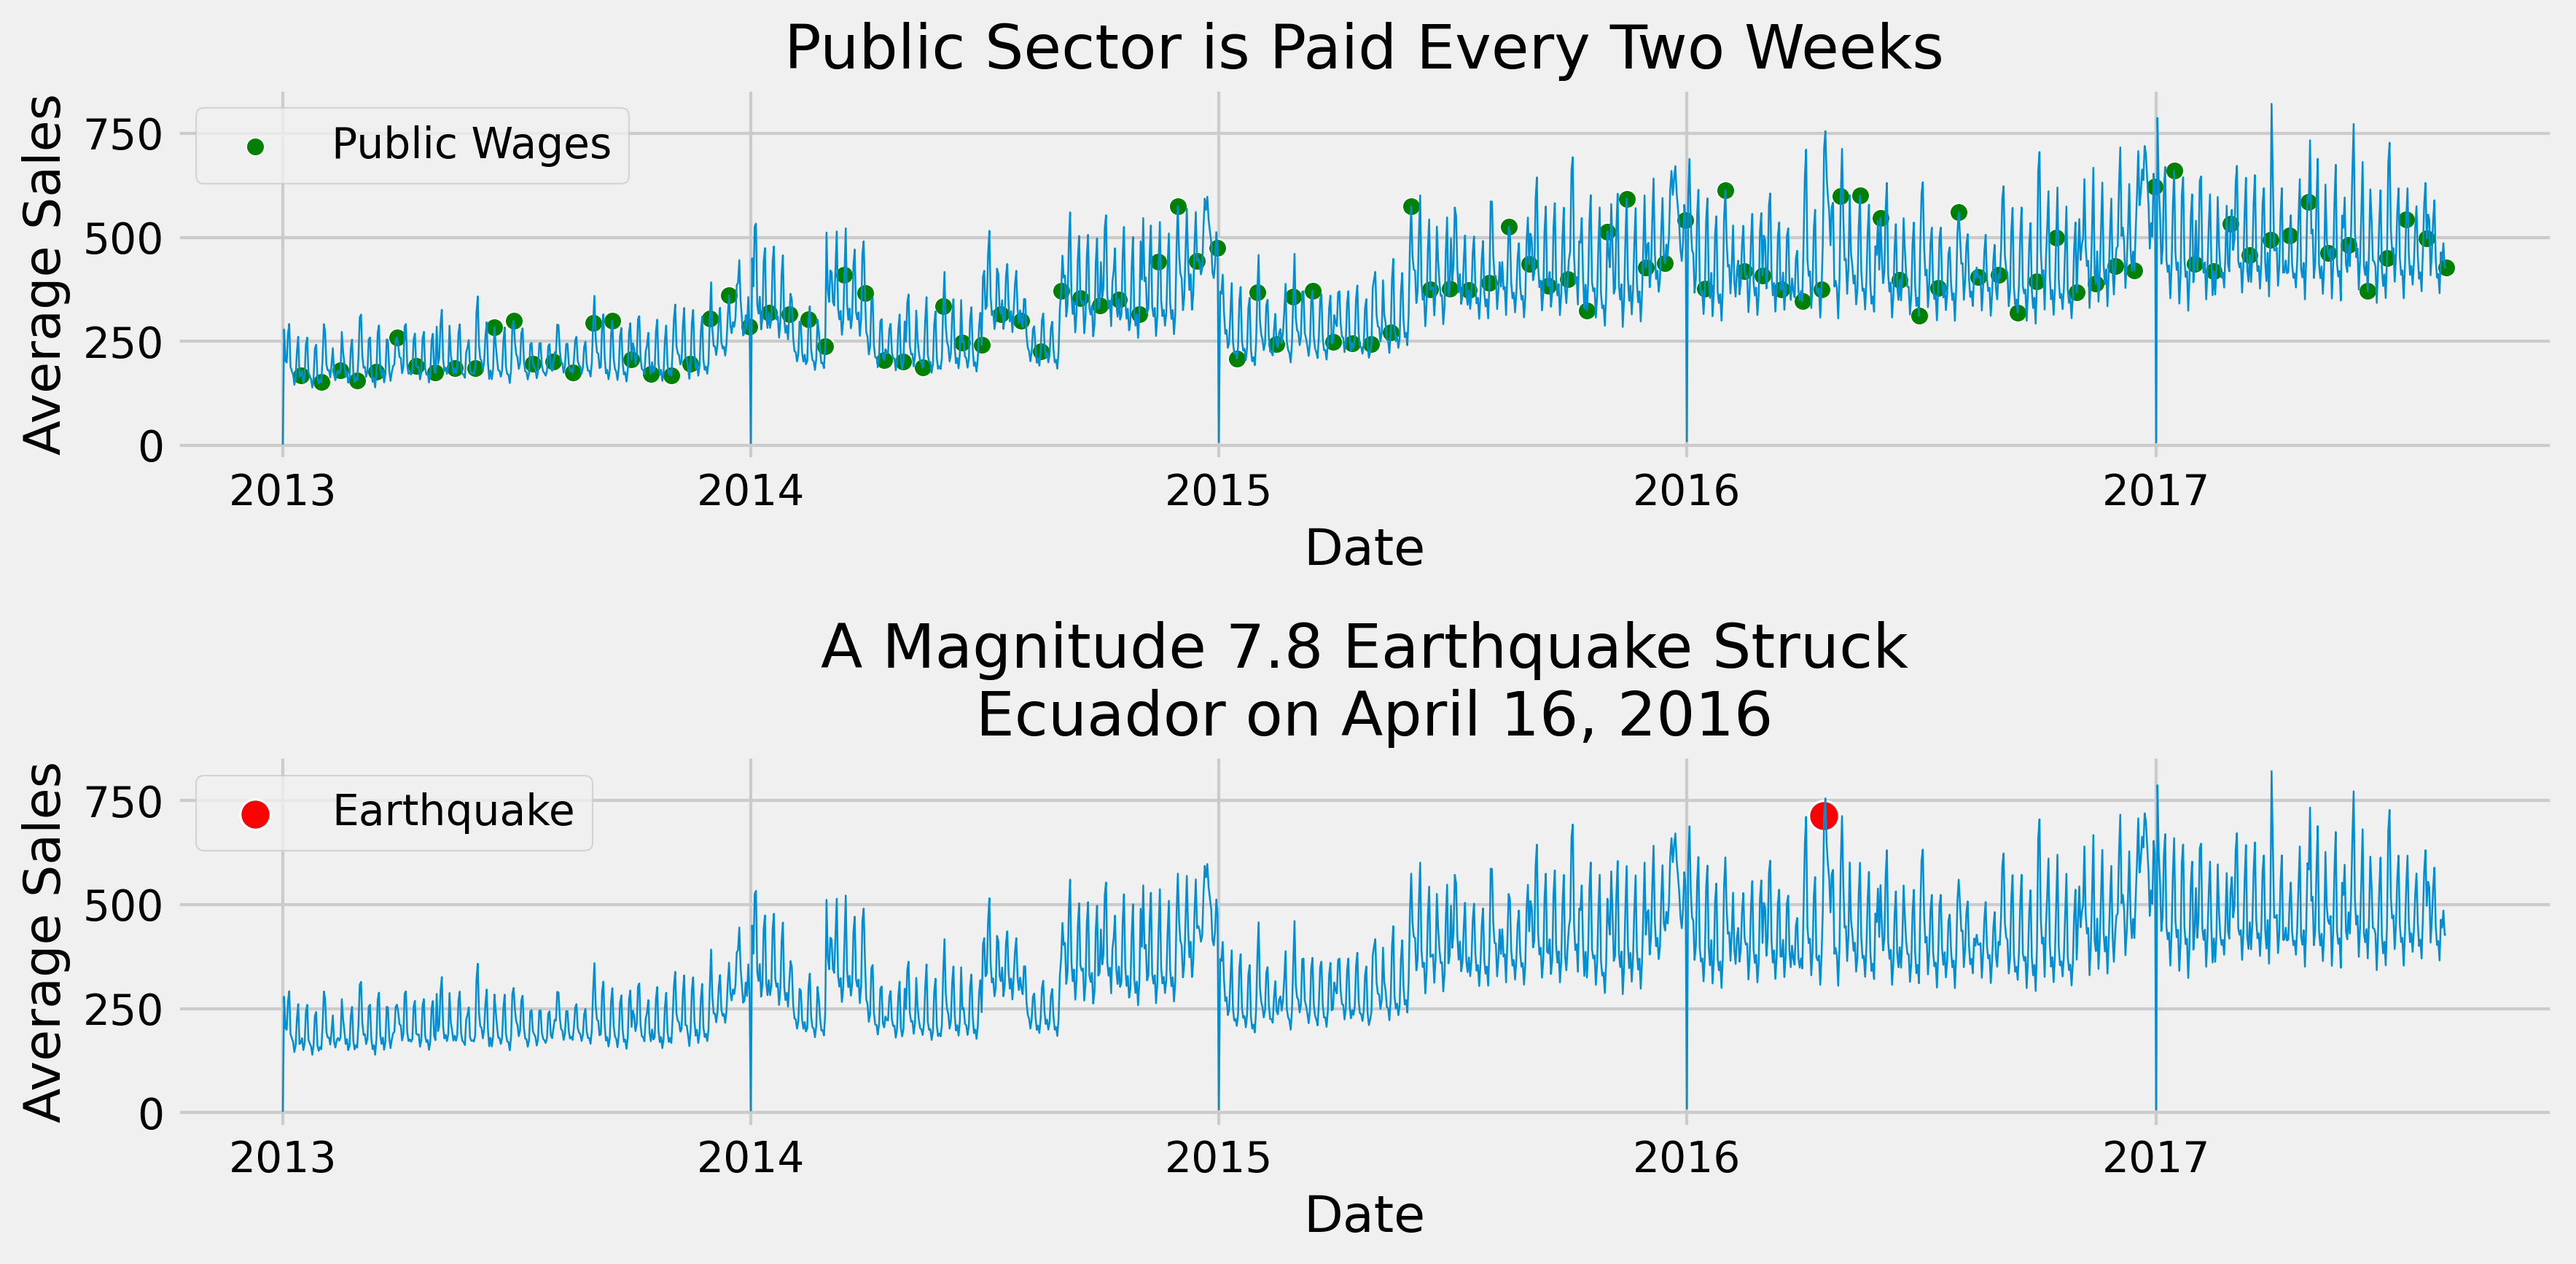

In [20]:
start_date = '2013-01-01'
end_date = '2017-08-15'

train_df_groupby = train_df.groupby('date')['sales'].mean().reset_index()
public_wages = train_df_groupby.loc[(train_df_groupby['date'].dt.day == 15) |\
                                    (train_df_groupby['date'].isin(pd.date_range(start=start_date, 
                                                                                 end=end_date, freq='M')))]

# Create a grid of subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Draw the first line plot for Oil Price on the first subplot
sns.lineplot(data=train_df.groupby('date')['sales'].mean().reset_index(), x='date', y='sales', lw=0.6, ax=axes[0])
sns.scatterplot(data=public_wages, x='date', y='sales', ax=axes[0], color='green', label='Public Wages')

# Add labels and title for the first subplot
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Average Sales")
axes[0].set_title("Public Sector is Paid Every Two Weeks")

# Draw the second line plot for Average Sales on the second subplot
sns.lineplot(data=train_df.groupby('date')['sales'].mean().reset_index(), x='date', y='sales', lw=0.6, ax=axes[1])
sns.scatterplot(data=train_df.groupby('date')['sales'].mean().to_frame().query("date == '2016-04-17'").reset_index(), 
                x='date', y='sales', color='red', label='Earthquake', s=100, ax=axes[1])
#plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='-', label='test', alpha=0.3)

# Add labels and title for the second subplot
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Average Sales")
axes[1].set_title("A Magnitude 7.8 Earthquake Struck\n Ecuador on April 16, 2016")

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

There're more items on promotion increasingly every year!

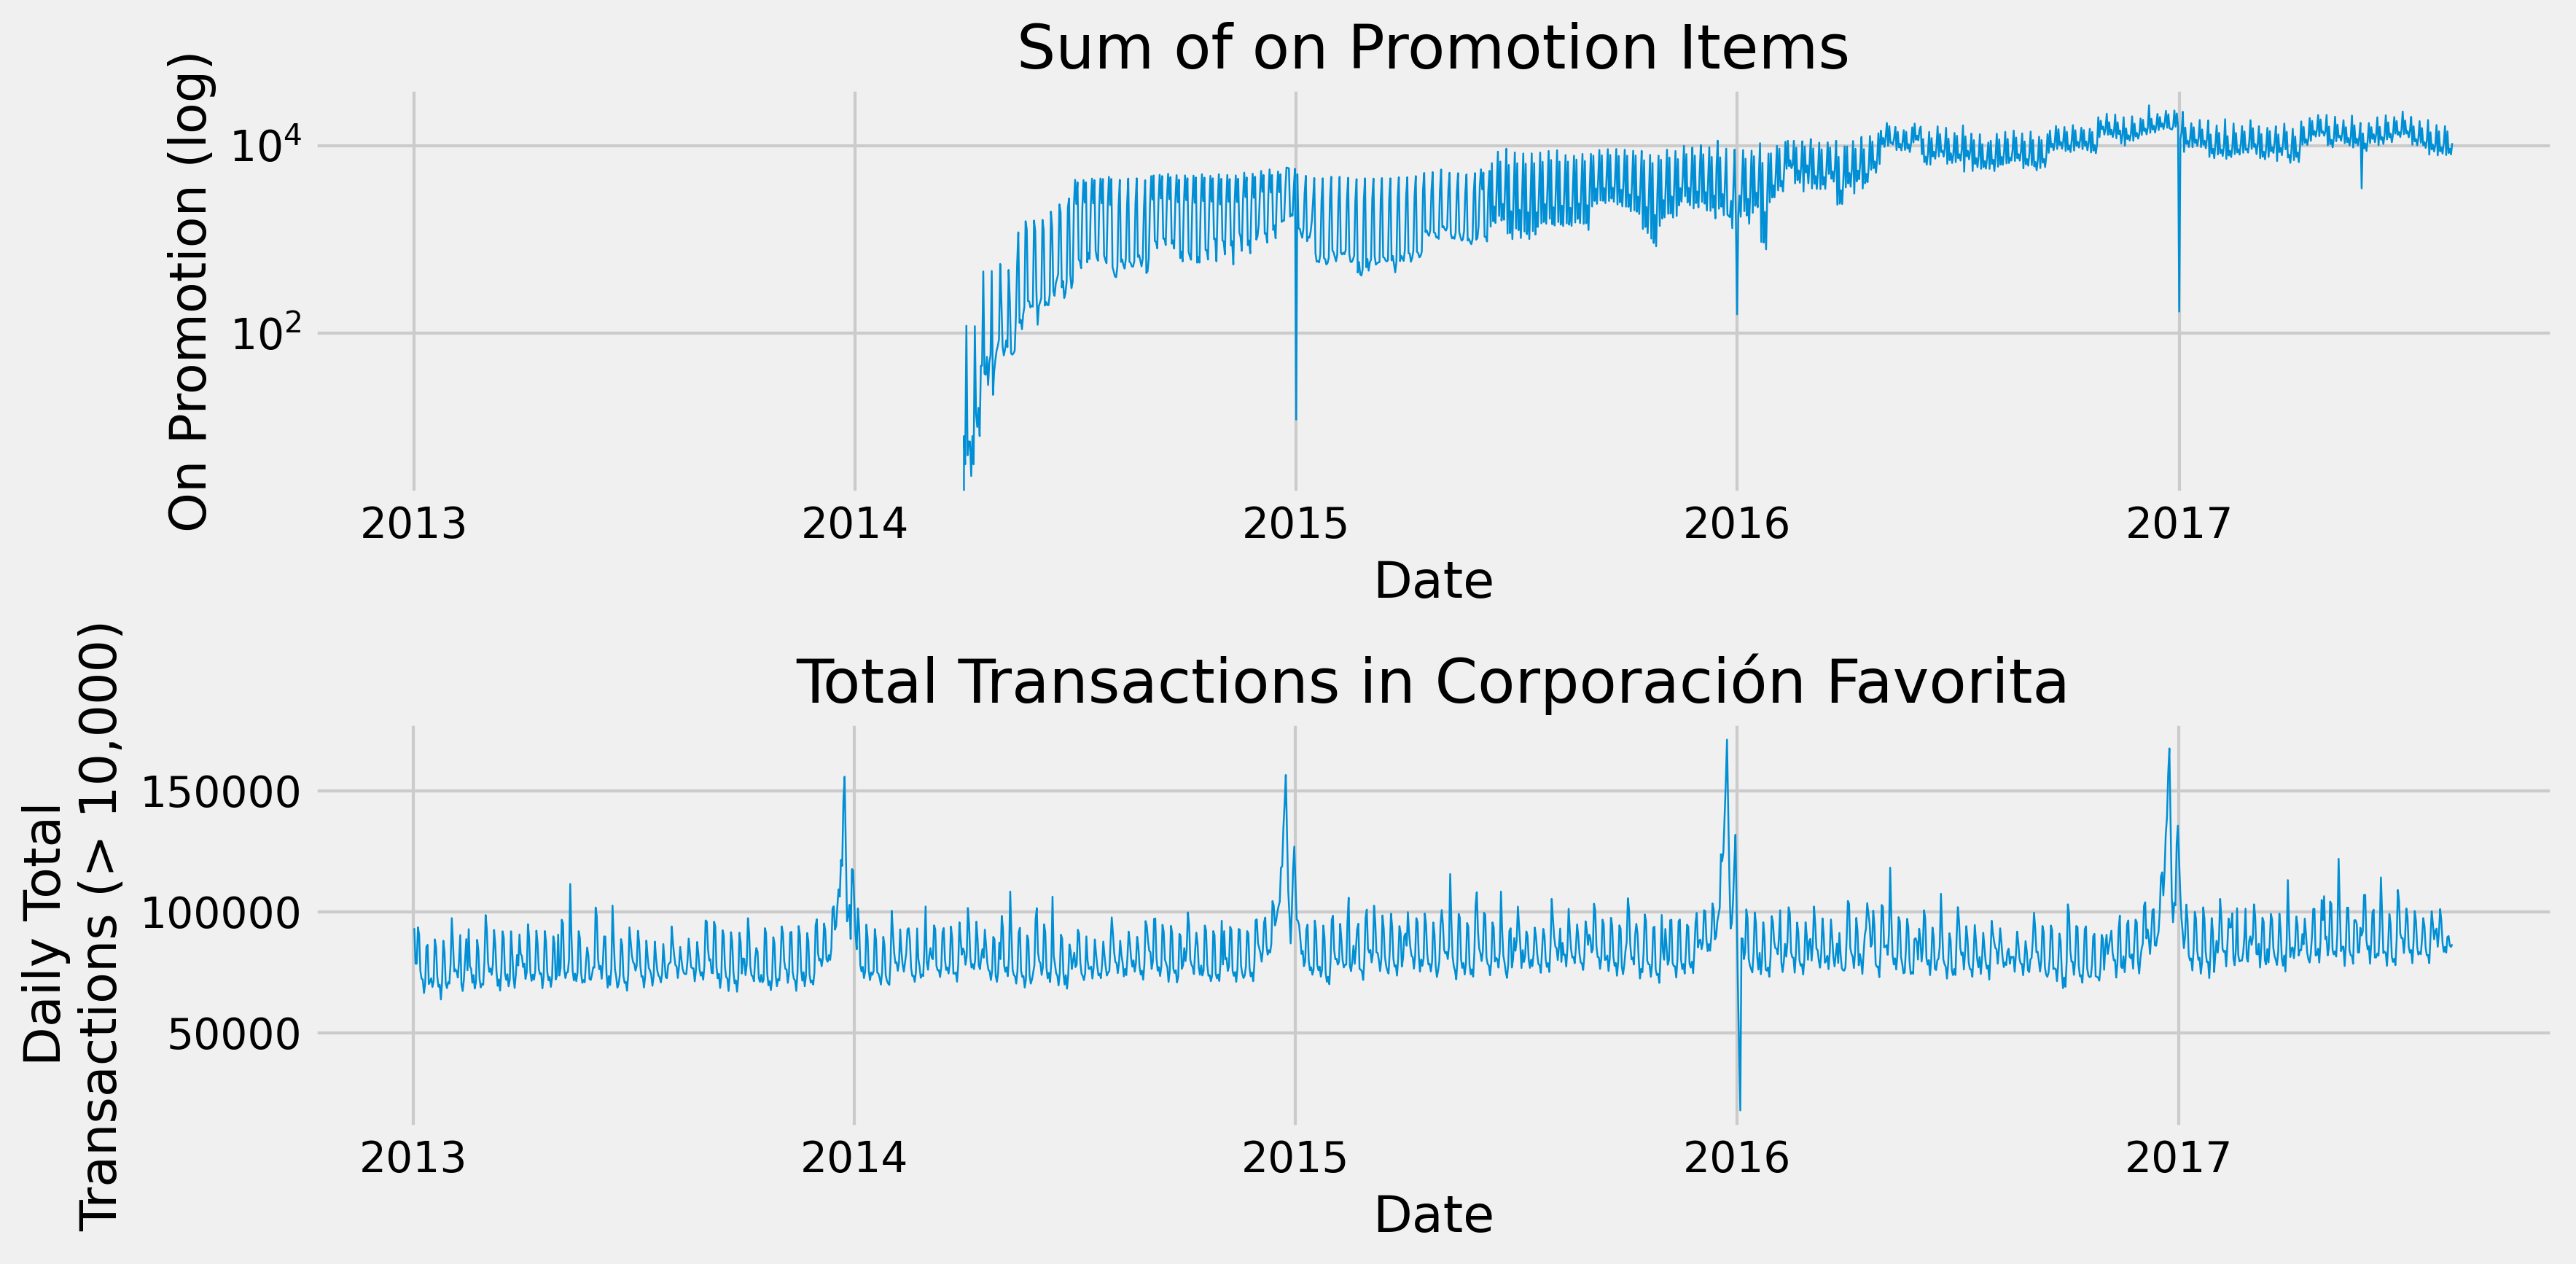

In [21]:
merge_df2 = pd.merge(left=train_df.groupby('date')['onpromotion'].sum().reset_index(), 
                     right=transactions_df.groupby('date')['transactions'].sum().reset_index(), 
                     how='left', 
                     on='date').fillna('0')

merge_df2['transactions'] = merge_df2['transactions'].astype('int')

# Create a grid of subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Draw the first line plot for Oil Price on the first subplot
sns.lineplot(x=merge_df2.date, y=merge_df2.onpromotion, lw=0.6, ax=axes[0])

# Add labels and title for the first subplot
axes[0].set_xlabel("Date")
axes[0].set_yscale('log')
axes[0].set_ylabel("On Promotion (log)")
axes[0].set_title("Sum of on Promotion Items")

# Draw the second line plot for Average Sales on the second subplot
sns.lineplot(data=merge_df2.query('transactions > 10000'), x='date', y='transactions', lw=0.6, ax=axes[1])

# Add labels and title for the second subplot
axes[1].set_xlabel("Date")
#axes[1].set_yscale('log')
axes[1].set_ylabel("Daily Total \nTransactions (> 10,000)")
axes[1].set_title("Total Transactions in Corporación Favorita")

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

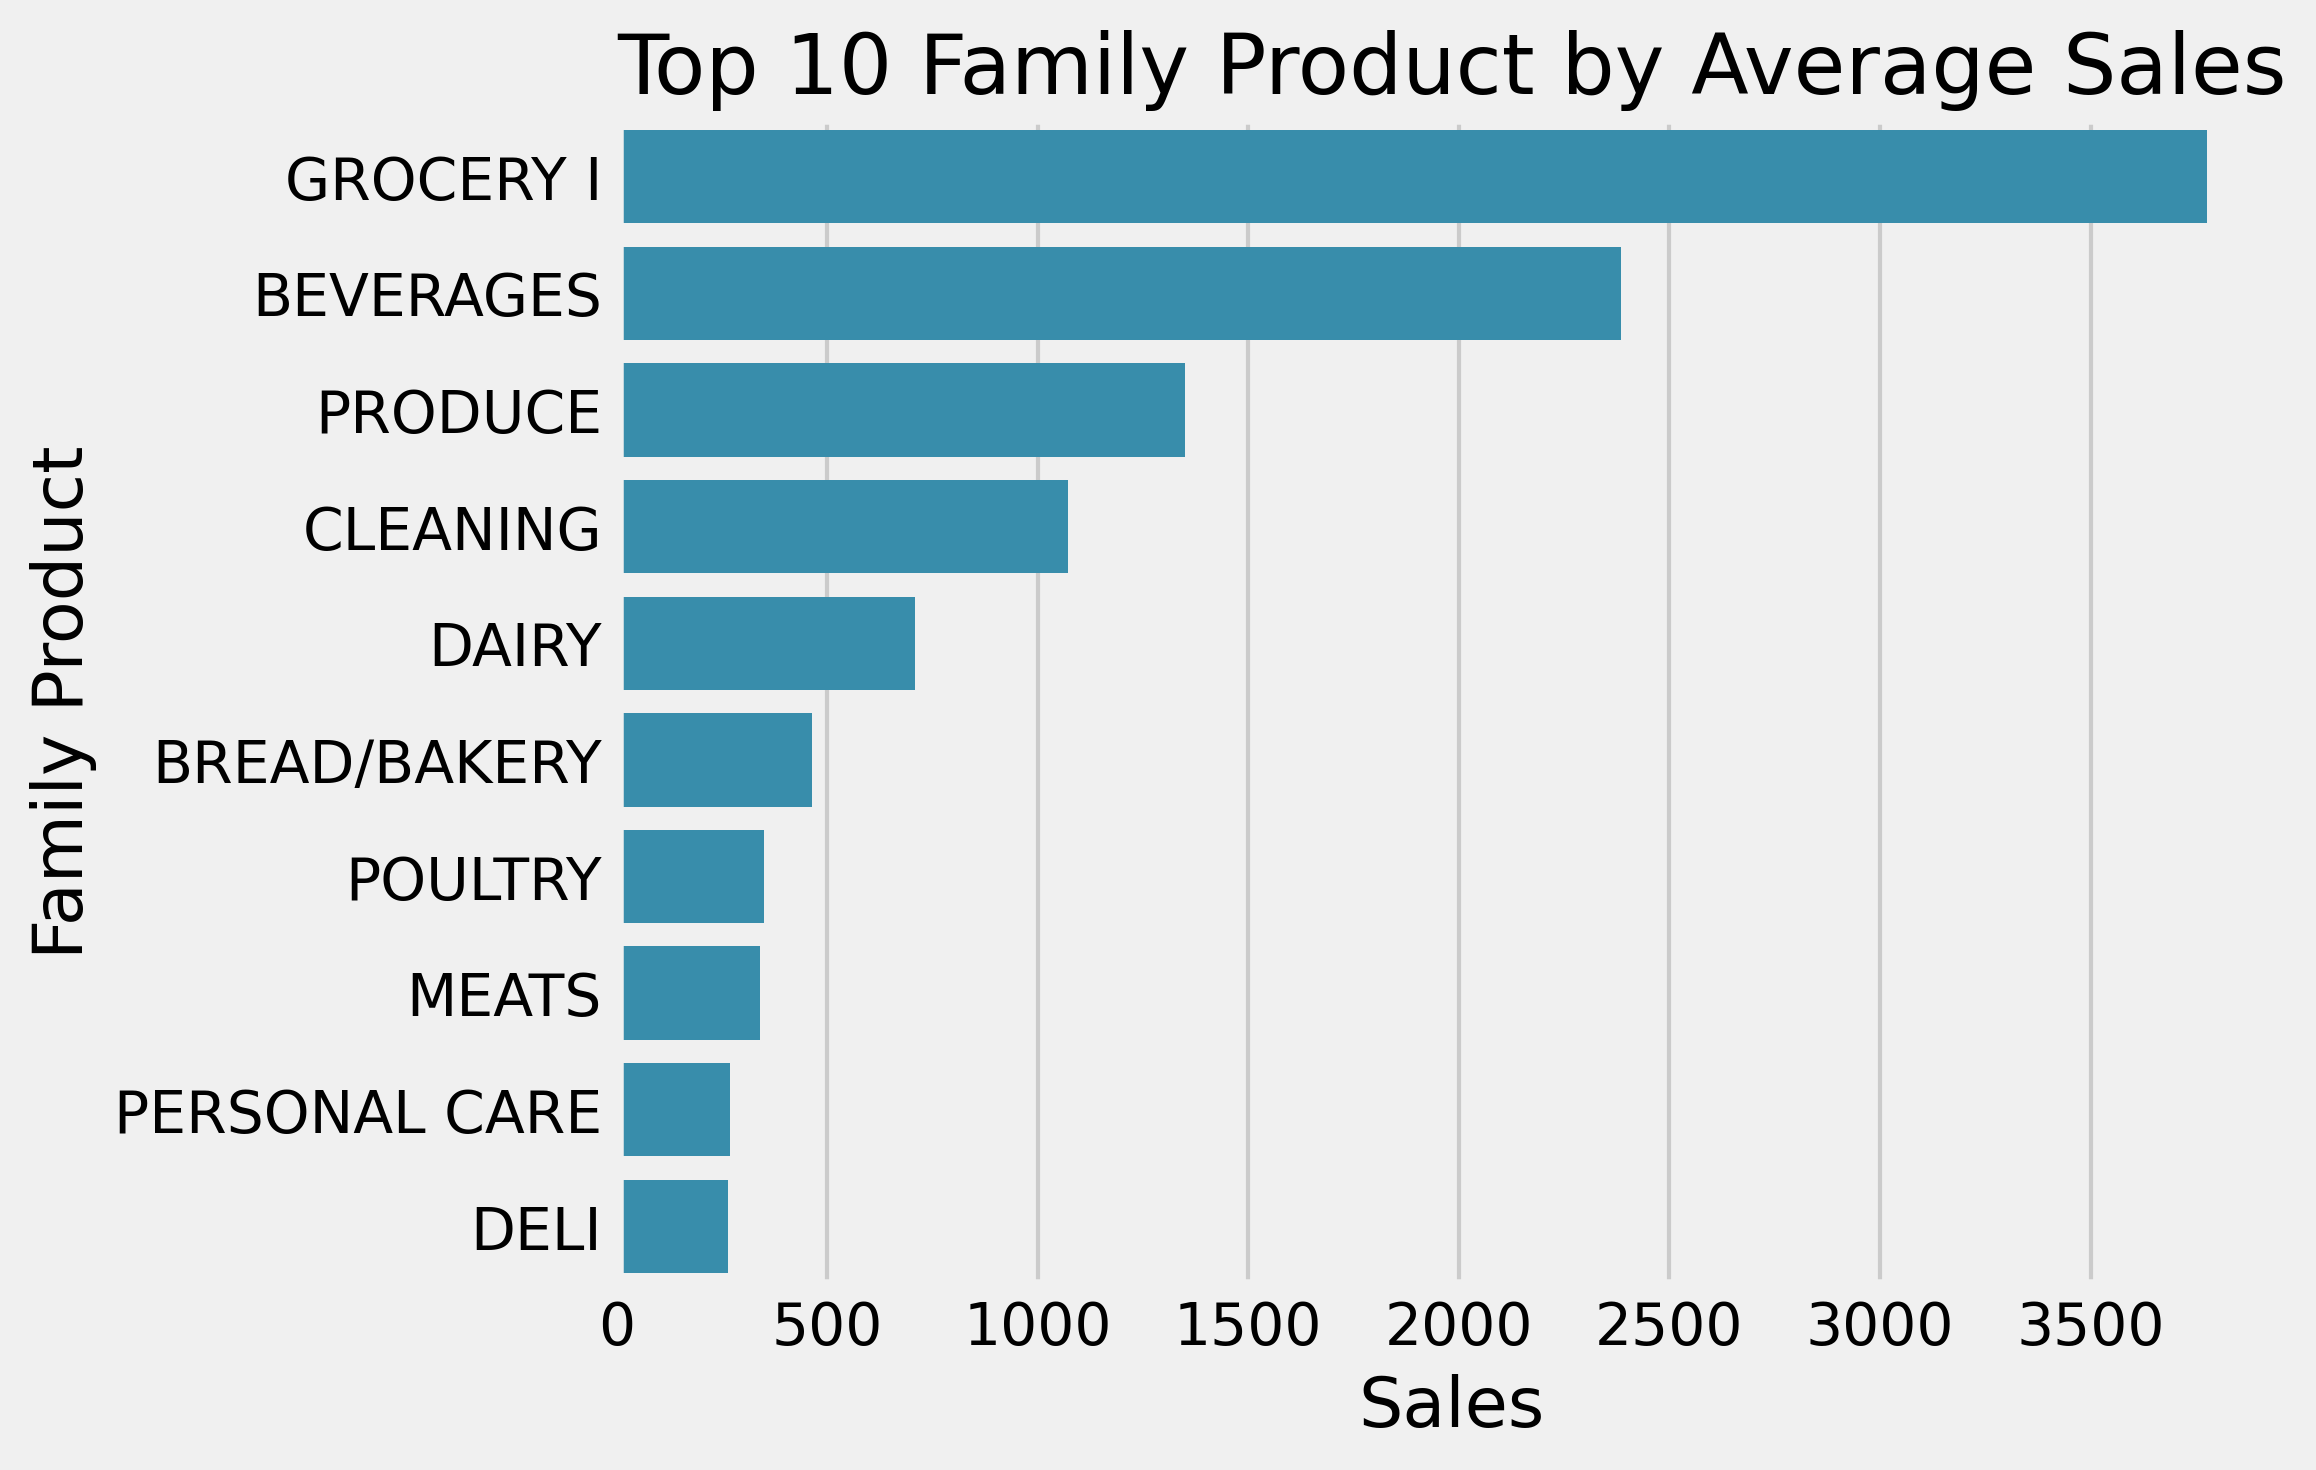

In [22]:
# the top 10 product family by sales

sns.barplot(data=train_df.groupby('family')['sales'].mean().sort_values(ascending=False)[:10].reset_index(), 
            x='sales', y='family', color='#2596be')

plt.title('Top 10 Family Product by Average Sales')
plt.ylabel('Family Product')
plt.xlabel('Sales')
plt.show()

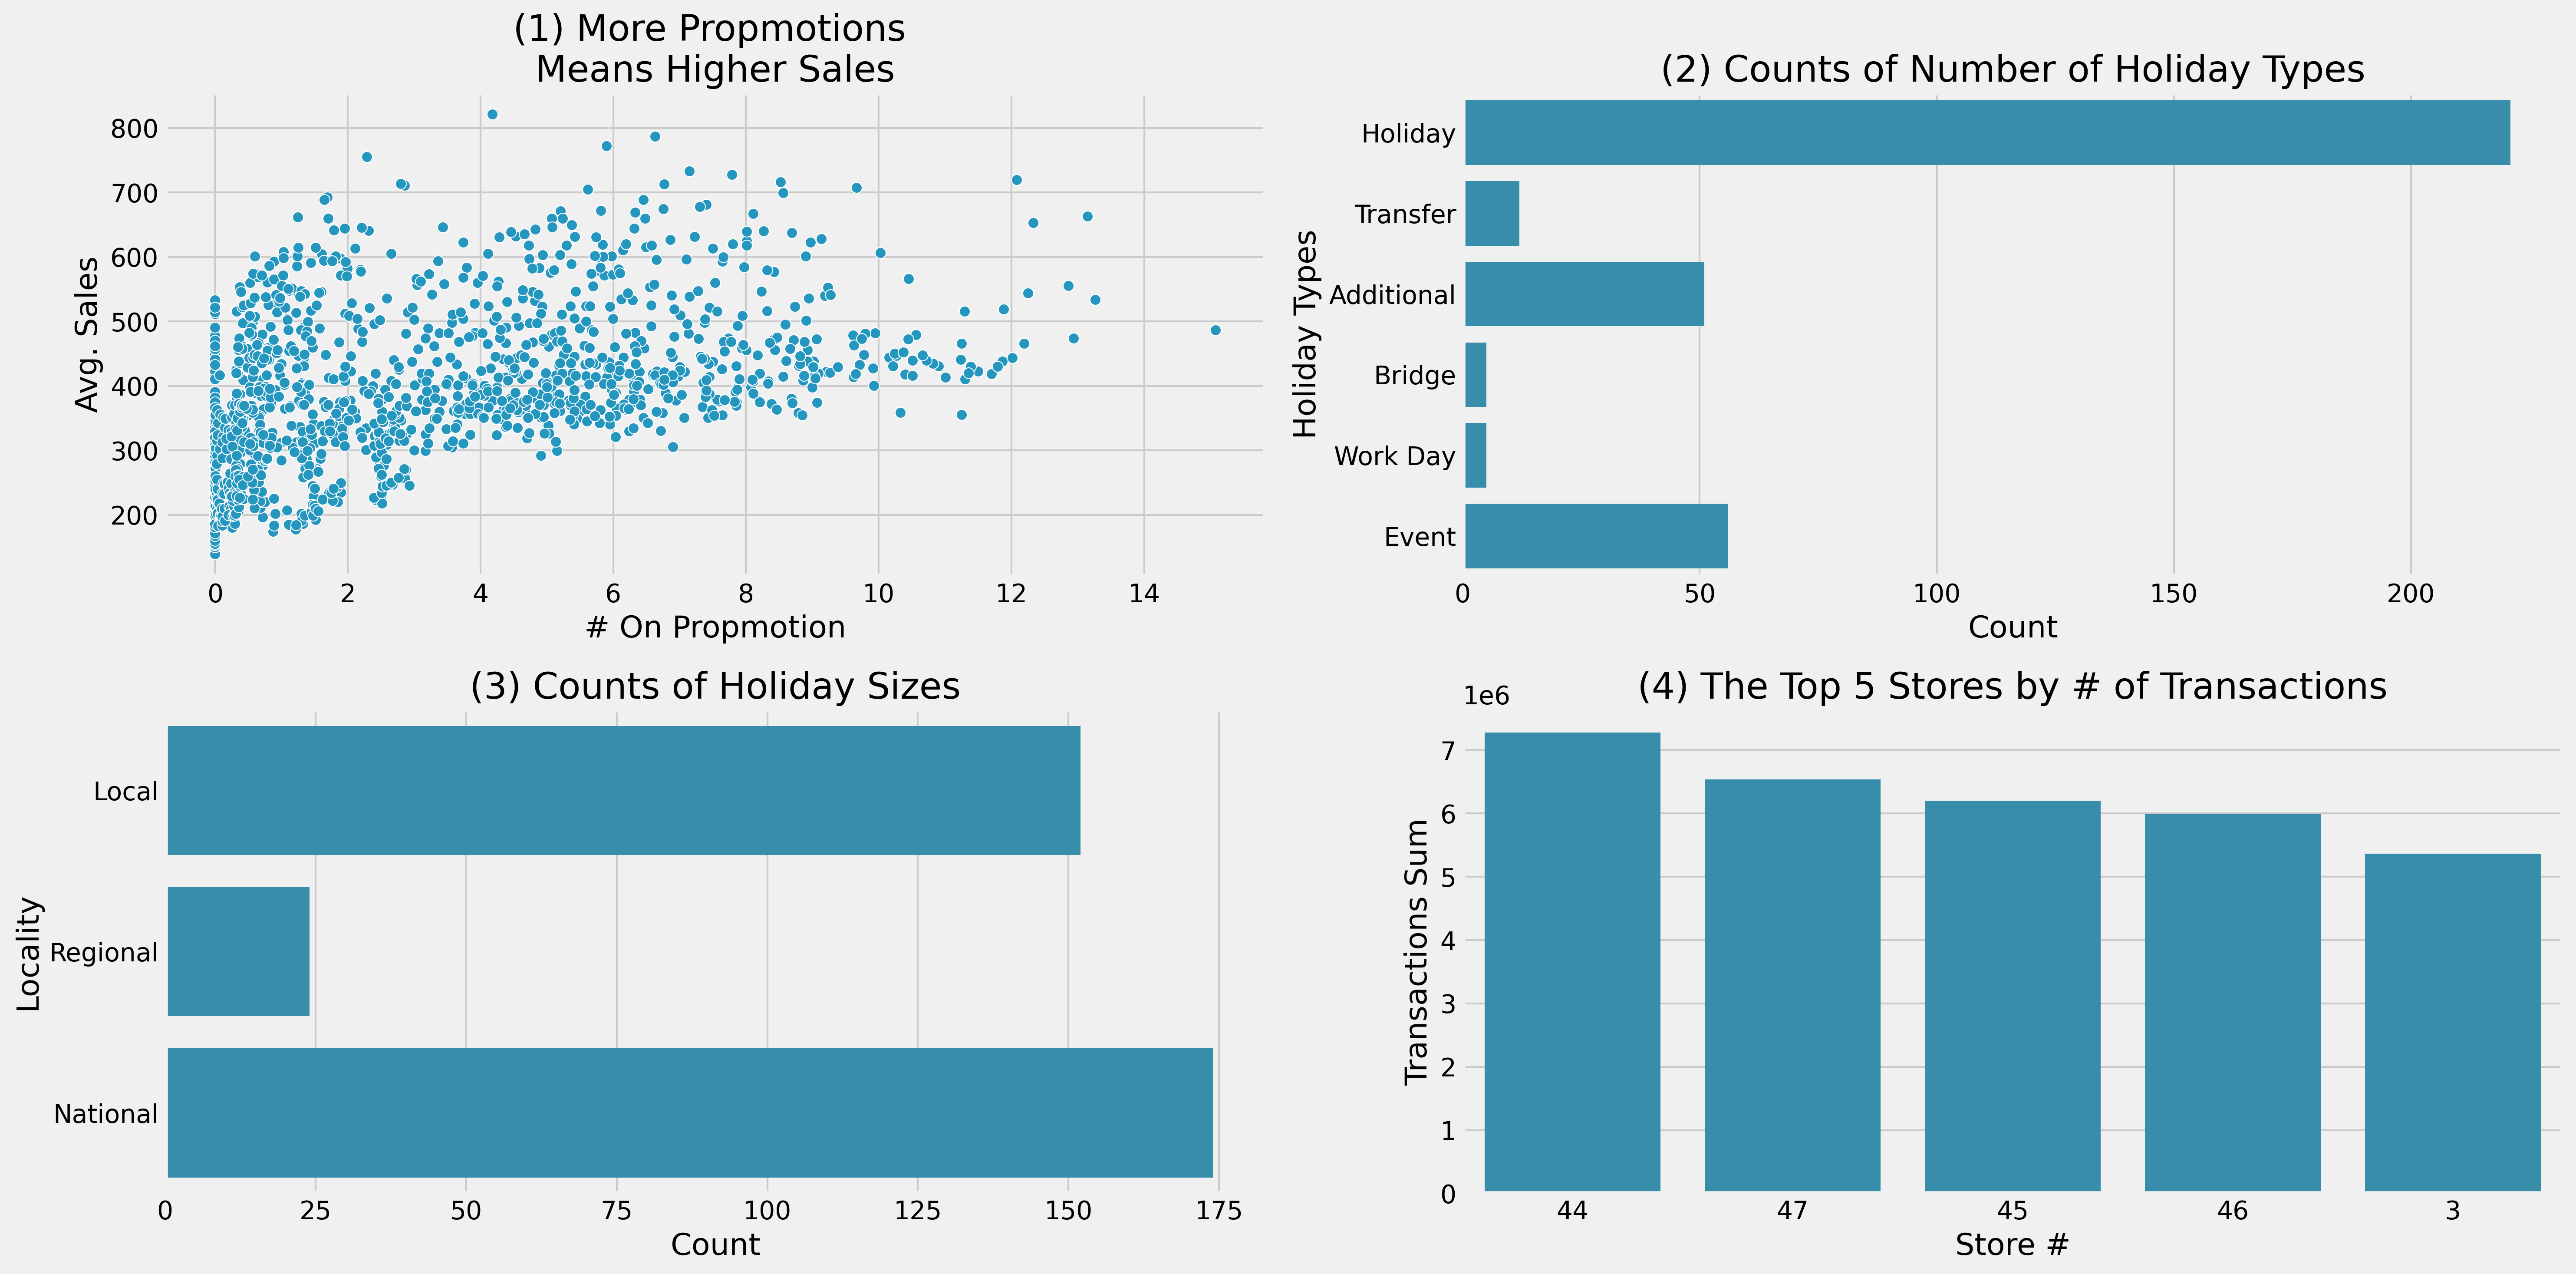

In [23]:
# more vizs

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.scatterplot(data=train_df.groupby('date')[['sales', 'onpromotion']].mean().query('sales > 100'), 
                x='onpromotion', y='sales', ax=axes[0, 0], color='#2596be')
axes[0,0].set_title('(1) More Propmotions \nMeans Higher Sales')
axes[0,0].set_xlabel('# On Propmotion')
axes[0,0].set_ylabel('Avg. Sales')

sns.countplot(data=holidays_events_df, y='type', ax=axes[0, 1], color='#2596be')
axes[0,1].set_title('(2) Counts of Number of Holiday Types')
axes[0,1].set_xlabel('Count')
axes[0,1].set_ylabel('Holiday Types')

sns.countplot(data=holidays_events_df, y='locale', ax=axes[1, 0], color='#2596be')
axes[1,0].set_title('(3) Counts of Holiday Sizes')
axes[1,0].set_xlabel('Count')
axes[1,0].set_ylabel('Locality')

sns.barplot(data=transactions_df.groupby('store_nbr')['transactions'].sum() \
            .sort_values(ascending=False).to_frame()[:5].reset_index(), 
            y='transactions', x='store_nbr', order=[44, 47, 45, 46, 3], ax=axes[1, 1], color='#2596be')
axes[1,1].set_title('(4) The Top 5 Stores by # of Transactions')
axes[1,1].set_xlabel('Store #')
axes[1,1].set_ylabel('Transactions Sum')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

What is the top CF store?

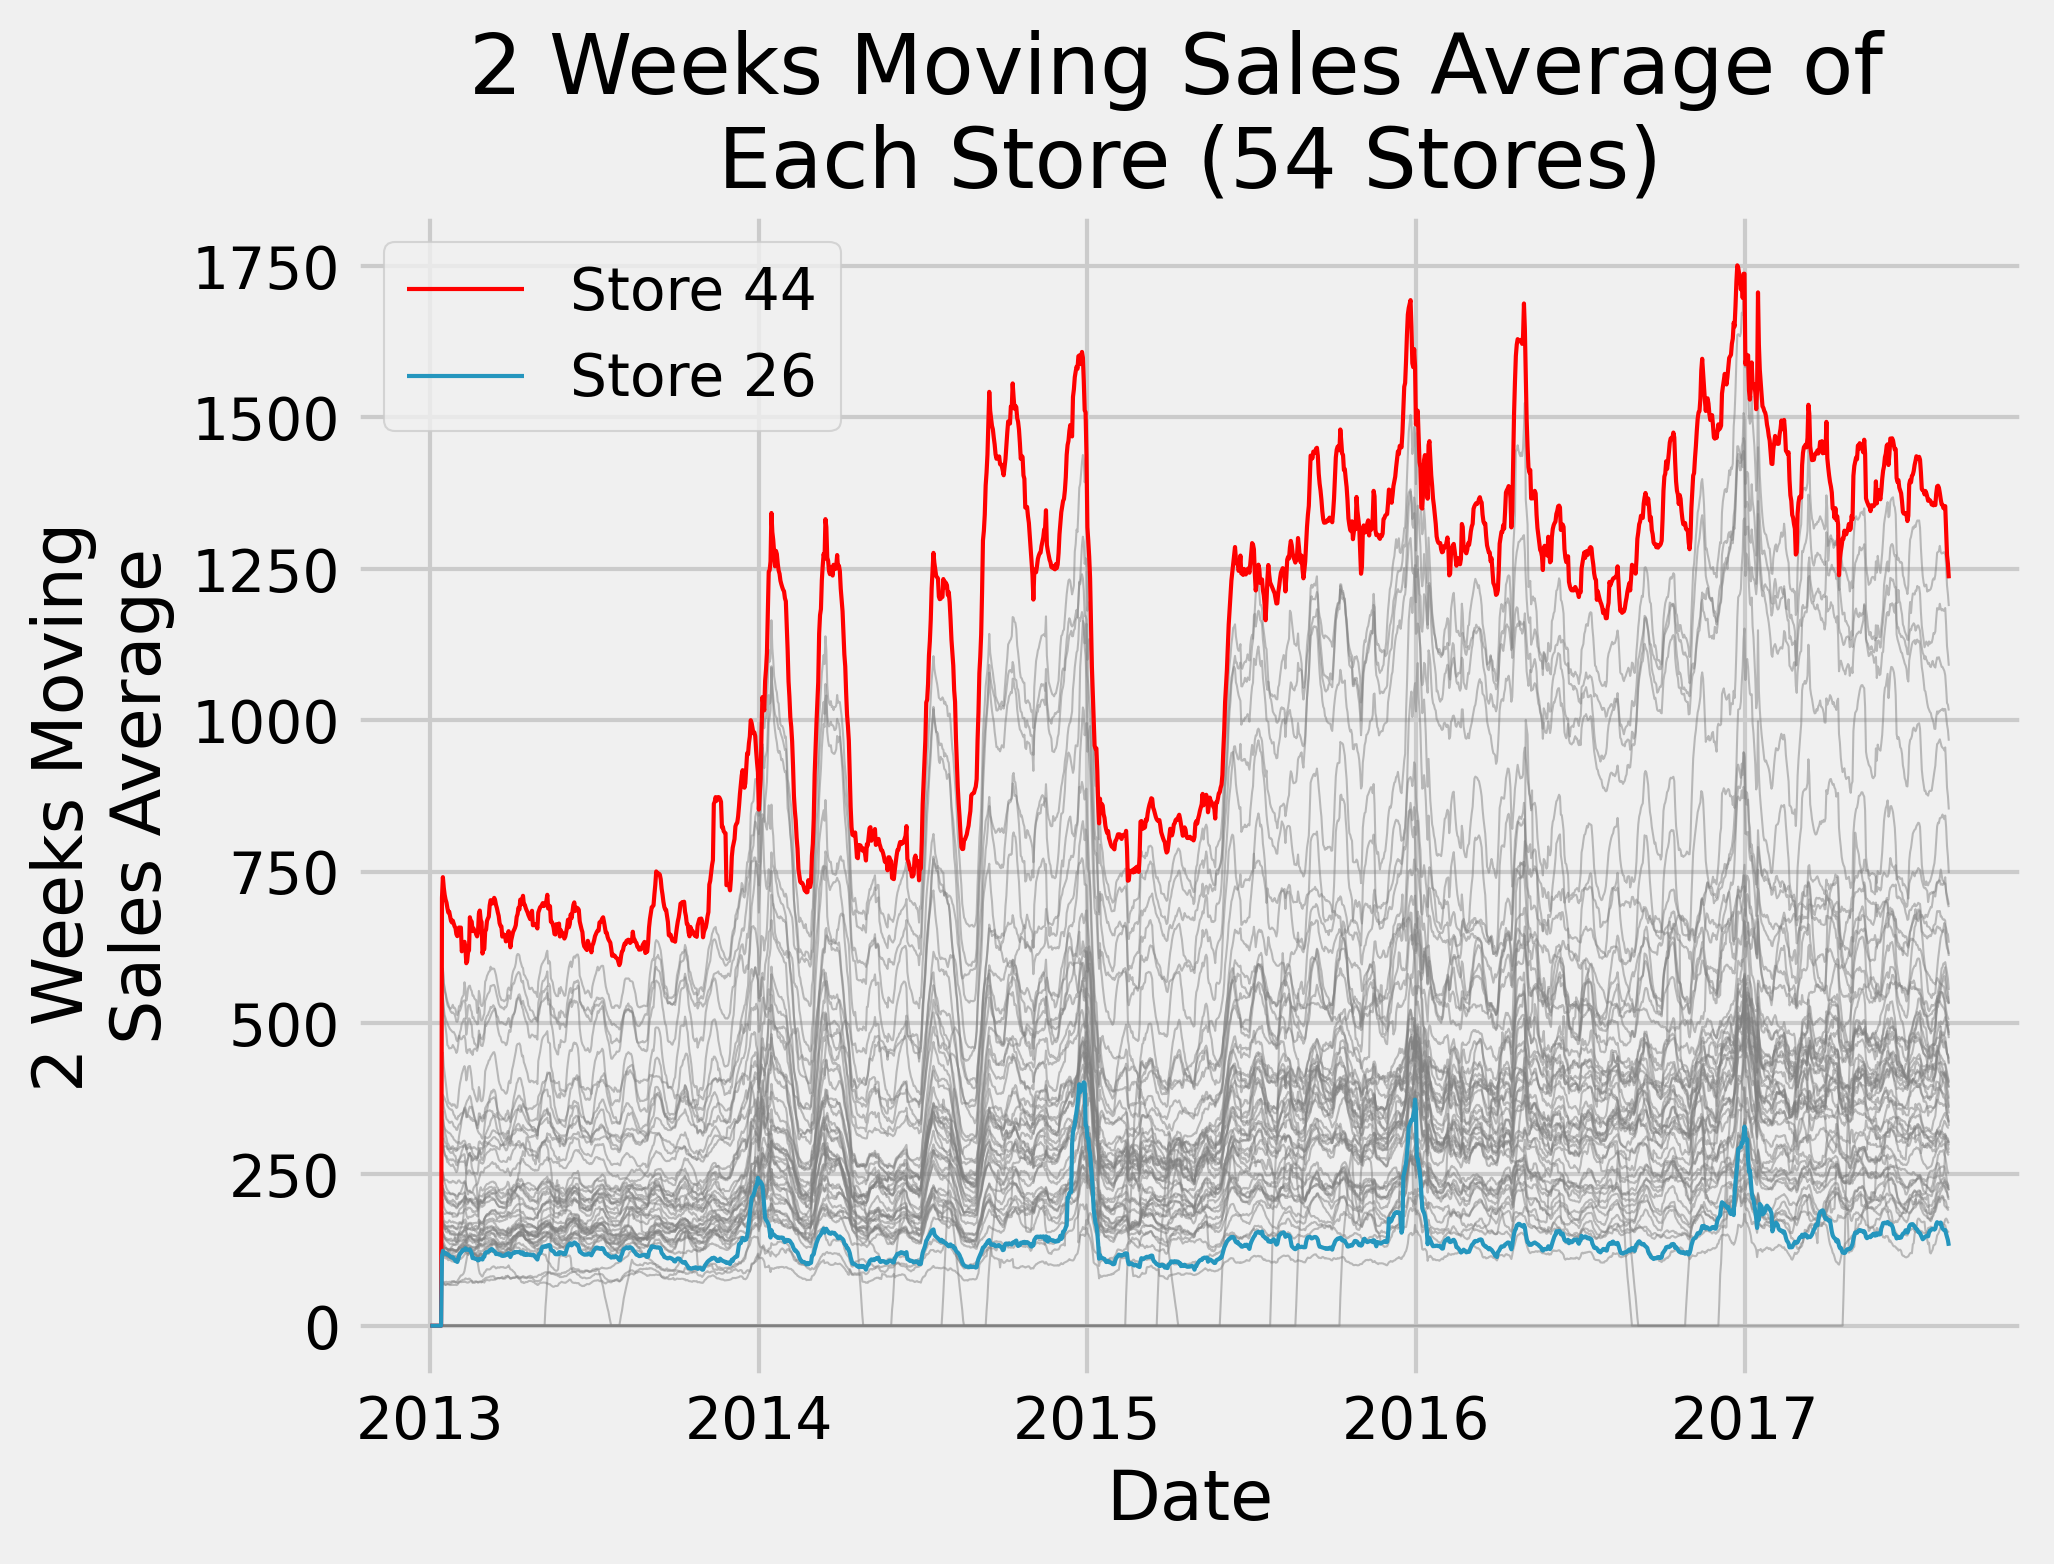

In [24]:
# top store

store_pivot = train_df.pivot_table(values='sales', index='date', 
                       columns='store_nbr', aggfunc=np.mean).rolling(window=14).mean().fillna(0)

for i in range(54):
    sns.lineplot(data=store_pivot.iloc[:,i].reset_index(), x='date', y=i+1, lw=0.5, color='gray', alpha=0.5)
    
sns.lineplot(data=store_pivot.iloc[:,43].reset_index(), x='date', y=44, 
             lw=1, color='red', alpha=1, label='Store 44')
sns.lineplot(data=store_pivot.iloc[:,25].reset_index(), x='date', y=26, 
             lw=1, color='#2596be', alpha=1, label='Store 26')
    
# add labels and title
plt.xlabel("Date")
plt.ylabel("2 Weeks Moving \nSales Average")
plt.title("2 Weeks Moving Sales Average of \nEach Store (54 Stores)")
plt.show()

Here are the top 3 family products and their avg. sales in the past five years.

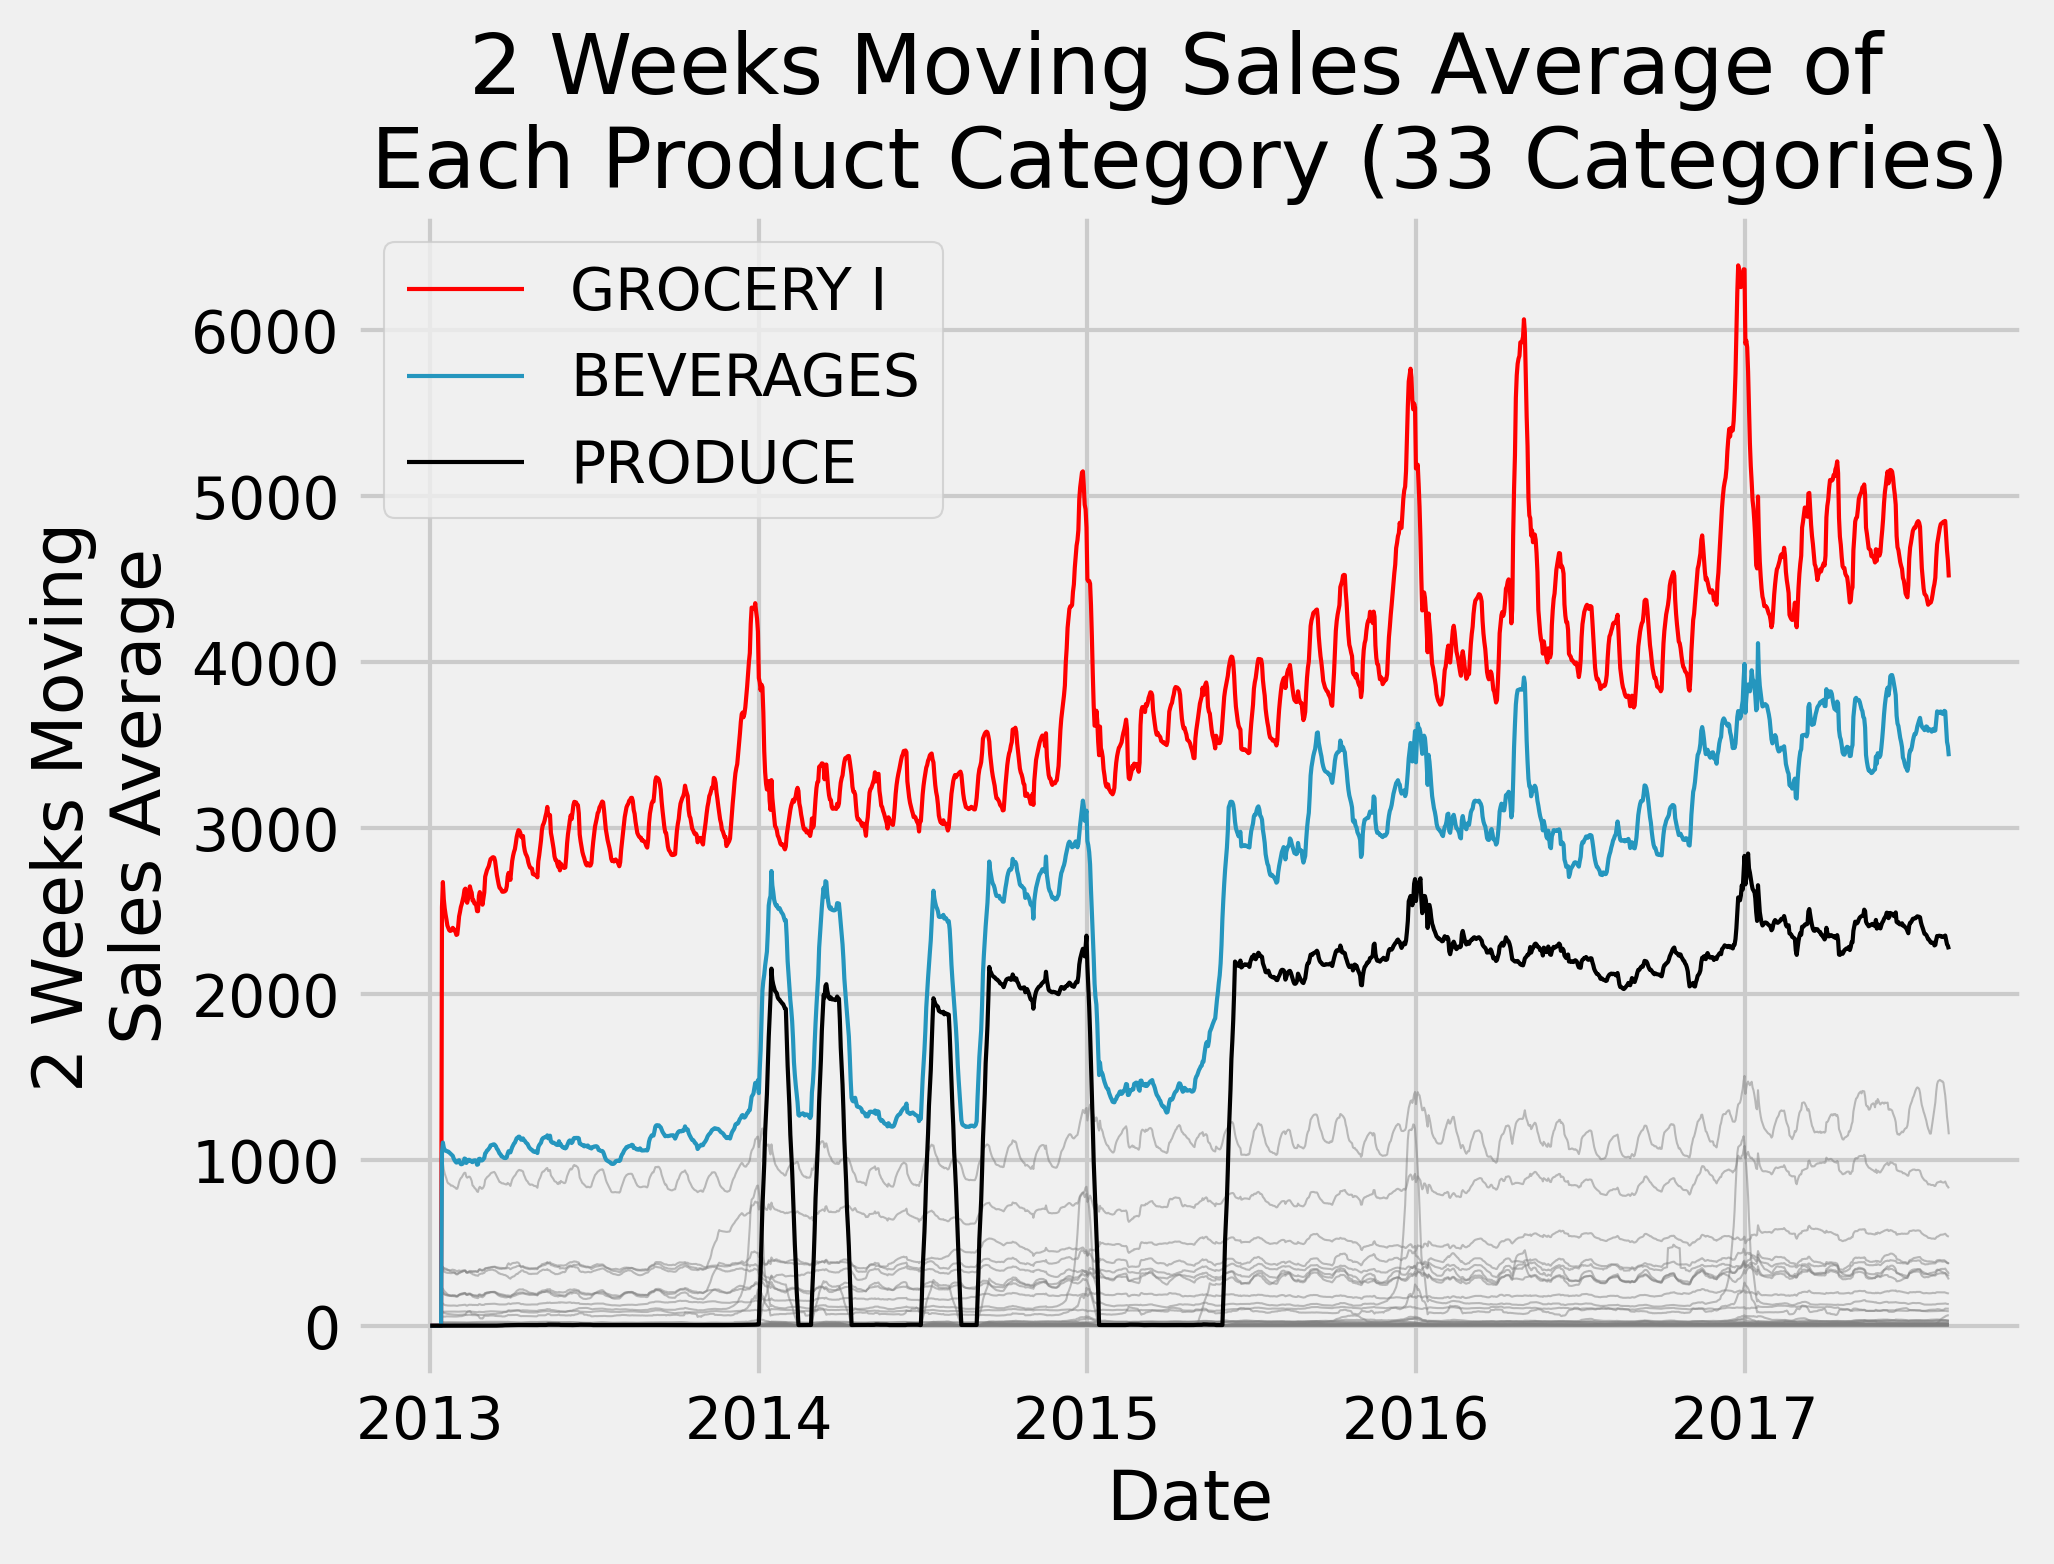

In [25]:
# top 3 products

product_pivot = train_df.pivot_table(values='sales', index='date', 
                       columns='family', aggfunc=np.mean).rolling(window=14).mean().fillna(0)

for idx, i in enumerate(product_pivot.columns):
    sns.lineplot(data=product_pivot.iloc[:,idx].reset_index(), x='date', y=product_pivot.columns[idx], 
                 lw=0.5, color='gray', alpha=0.5)
    
sns.lineplot(data=product_pivot.loc[:,'GROCERY I'].reset_index(), x='date', y='GROCERY I', 
             lw=1, color='red', alpha=1, label='GROCERY I')
sns.lineplot(data=product_pivot.loc[:,'BEVERAGES'].reset_index(), x='date', y='BEVERAGES', 
             lw=1, color='#2596be', alpha=1, label='BEVERAGES')
sns.lineplot(data=product_pivot.loc[:,'PRODUCE'].reset_index(), x='date', y='PRODUCE', 
             lw=1, color='black', alpha=1, label='PRODUCE')

# add labels and title
plt.xlabel("Date")
plt.ylabel("2 Weeks Moving \nSales Average")
plt.title("2 Weeks Moving Sales Average of \nEach Product Category (33 Categories)")
plt.show()

# Model Prediction

The baseline Score (just the raw dataframe) is 0.55088 using Random Forest Regressor. Let's see if we can imporve the **RMSLE**.

In [26]:
# get regression models from pycaret

from pycaret.regression import *

In [27]:
# setup the models

s = setup(train_df, 
          target = 'sales', 
          session_id = 1, categorical_features= ['store_nbr', 'family'], 
          fold = 2, date_features= ['date'],
          pca = True)

In [28]:
# get the best model

best_model = compare_models(fold=2)

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [29]:
features = ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'type_holiday', 'locale']

In [30]:
# setup for just one model (with 2 new features)

s = setup(train_master[features], 
          target = 'sales', 
          session_id = 1, categorical_features= ['store_nbr', 'family', 'type_holiday', 'locale'], 
          fold = 2, date_features= ['date'],
          pca = True)

In [31]:
# train the best model (rf) using the new features

rf = create_model('rf', fold=2)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
# remove sales from the list of features

features.remove('sales')

In [33]:
# predict on new data (df_test)

pred_test = predict_model(rf, data=test_master[features])

# putting the submission together

Submission = pd.DataFrame(data={'id':test_df.id, 'sales':pred_test['prediction_label']})

# saving the predictions in a csv file for submission

Submission.loc[Submission.sales < 0, 'sales'] = 0

Submission.to_csv('submission.csv', index=False)

Submission.head()

id        sales
0  3000888     2.890000
1  3000889     1.040000
2  3000890     4.700000
3  3000891  2811.098191
4  3000892     0.150000

Finally, this new model has 0.60946 RMSLE. The base model is better!